In [3]:
import pandas as pd
import numpy as np
import re
from itertools import count
from collections import Counter
import os

# Data wrangling


##1) The "hospital" data"
### The hospital datasets contain a list of all hospital institutions in Switzerland with data about the infrastructure and the economic situation of each institutions. There are 6 datasets, one for each year from 2016-21.
###The aim of this first part is to import and clean the dataset to make it compatible with the "sites" datasets, datasets that contain information about each site of each hospital institution.
###In a further step, the data about the hospitals and the sites will be combined with local political and economical data for the descriptive and machine learning analysis.

### 1.1. Importing the datasets

In [1]:
# Upload the local data file to colab
from google.colab import files
uploaded = files.upload()

Saving h2016.xlsx to h2016.xlsx
Saving h2017.xlsx to h2017.xlsx
Saving h2018.xlsx to h2018.xlsx
Saving h2019.xlsx to h2019.xlsx
Saving h2020.xlsx to h2020.xlsx
Saving h2021.xlsx to h2021.xlsx


In [4]:
h2016 = pd.read_excel('h2016.xlsx')
h2017 = pd.read_excel('h2017.xlsx')
h2018 = pd.read_excel('h2018.xlsx')
h2019 = pd.read_excel('h2019.xlsx')
h2020 = pd.read_excel('h2020.xlsx')
h2021 = pd.read_excel('h2021.xlsx')

In [5]:
h_allyears = [h2016, h2017, h2018, h2019,h2020,h2021]
h_allyears_name = ['h2016','h2017', 'h2018', 'h2019','h2020','h2021']

In [6]:
#print shape of all the datasets
for dataset, name in zip(h_allyears, h_allyears_name):
    print(f"{name} shape:", dataset.shape)

h2016 shape: (285, 138)
h2017 shape: (283, 139)
h2018 shape: (282, 139)
h2019 shape: (282, 141)
h2020 shape: (277, 140)
h2021 shape: (277, 146)


In [7]:
#print head of all the datasets
for dataset, name in zip(h_allyears, h_allyears_name):
    print(f"{name} shape:", dataset.head)

h2016 shape: <bound method NDFrame.head of       KT                         Inst                       Adr  \
0     AG             RehaClinic Baden           Bäderstrasse 16   
1     AG      Hirslanden Klinik Aarau              Schänisweg 1   
2     AG         Klinik Barmelweid AG                       NaN   
3     AG  Kreisspital für das Freiamt         Spitalstrasse 144   
4     AG  Geburtshus Storchenäscht AG     Hendschikerstrasse 12   
..   ...                          ...                       ...   
280   ZH      RehaClinic Zollikerberg  Trichtenhauserstrasse 20   
281   ZH         RehaClinic Kilchberg            Grütstrasse 60   
282   ZH              Eulachklinik AG              Brunngasse 6   
283  NaN                          NaN                       NaN   
284  NaN                Ganze Schweiz                       NaN   

                   Ort   Typ RForm         Akt       SL              WB  \
0           5401 Baden  K221    R1           R      NaN  MSt, Arzt, BGs   
1 

In [8]:
#deleting the last row as it is a summary for all Switzerland
for dataset in h_allyears:
    dataset.drop(dataset.index[-1], inplace=True)

In [9]:
#deleting one more row for 2016&17
h2016.drop(h2016.index[-1], inplace=True)
h2017.drop(h2017.index[-1], inplace=True)

In [10]:
#find the list of the common variables over the years
common_columns = set(h_allyears[0].columns)

for dataset in h_allyears[1:]:
    common_columns = common_columns.intersection(set(dataset.columns))

common_columns_list = list(common_columns)
print(common_columns_list)

['KostOKPAmbB', 'BettenStatB', 'Inst', 'DADStatMSA', 'KostAmbP', 'ErlKVGStatB', 'PtageStatMSP', 'PtageStatMSR', 'PersP', 'ErlOKPAmbA', 'AmbKonsR', 'pMRI_STAT', 'KT', 'EtSonst', 'BettenStatP', 'AmbKonsB', 'AnlZvOKPStatR', 'ErlZvOKPStatVR', 'ErlOKPAmbP', 'pCT_STAT', 'DADStatMSR', 'KostOKPAmbP', 'KostForLFA', 'KostAmbB', 'KostOKPAmbR', 'PtageStatMSB', 'EtSubv', 'KostZvOKPStatP', 'KostStatR', 'PtageStatMST', 'pANGIO_AMB', 'ErlZvOKPStatVP', 'AnlZvOKPStatB', 'AustStatMSR', 'ErlKVGStatP', 'Typ', 'pPatHOK', 'SL', 'ErlZvOKPStatB', 'AmbKonsP', 'pBettenBelStatB', 'BettenStatR', 'KostAWLFP', 'AnlKVGStatP', 'AnzStand', 'RForm', 'AwBesold', 'pBettenBelStatP', 'KostStatA', 'KostAWLFB', 'AustStatMSA', 'ErlZvOKPStatP', 'KostAmbA', 'KostWBLFR', 'AnlKVGStatR', 'ErlZvOKPStatR', 'pBettenBelStatR', 'LA', 'SA', 'PersA', 'ErlKVGStatVP', 'StdBelP', 'KostKVGStatP', 'ErlZvOKPStatVB', 'pPatLKP', 'AustStatMST', 'KostWBLFA', 'AmbKonsA', 'AnlKVGStatA', 'AustStatMSP', 'ErlAmbStatLangB', 'KostKVGStatR', 'ErlOKPAmbB', 

In [11]:
#find out whether the columns that I need for the further analysis are consistent in all datasets
hall_columns_needed = ["KT", "Inst", "Ort", "RForm", "Typ", "SL", "AnzStand", "AmbKonsT", "Ops", "Gebs", "pPatWAK", "pPatLKP", "pPatHOK", "PersA", "PersP", "PersT", "AwBesold", "AwInvest", "EtMedL", "EtSubv", "FiErg"]

not_present_columns = [column for column in hall_columns_needed if column not in common_columns_list]

print(not_present_columns)

[]


In [12]:
#keeping only the needed columns in all datasets
for dataset in h_allyears:
    columns_to_drop = set(dataset.columns).difference(hall_columns_needed)
    dataset.drop(columns=columns_to_drop, inplace=True)

In [13]:
for dataset, name in zip(h_allyears, h_allyears_name):
    print(f"{name}:")
    print(dataset.columns)
    print(dataset.shape)

h2016:
Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dtype='object')
(283, 21)
h2017:
Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dtype='object')
(281, 21)
h2018:
Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dtype='object')
(281, 21)
h2019:
Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dt

### 1.2. Cleaning the data to make it compatible with further datasets
### The hospital datasets do not use the official municipality numbers. The first step of this further cleaning is therefore to associate each municipality with its official FSO number-

In [14]:
#Importing the official list of all swiss municipalities
from google.colab import files
uploaded = files.upload()

Saving bfs_munic.xlsx to bfs_munic.xlsx


In [15]:
bfs_munic = pd.read_excel('bfs_munic.xlsx') #the datasets contains the official FSO numbers for each municipalities. These numbers are used to identify the municipalities across different data sources

In [16]:
bfs_munic.head

<bound method NDFrame.head of      GDEKT  GDEBZNR  GDENR             GDENAME             GDENAMK  \
0       ZH      101      1     Aeugst am Albis     Aeugst am Albis   
1       ZH      101      2  Affoltern am Albis  Affoltern am Albis   
2       ZH      101      3          Bonstetten          Bonstetten   
3       ZH      101      4     Hausen am Albis     Hausen am Albis   
4       ZH      101      5            Hedingen            Hedingen   
...    ...      ...    ...                 ...                 ...   
2131    JU     2603   6807       Basse-Allaine       Basse-Allaine   
2132    JU     2603   6808       Clos du Doubs       Clos du Doubs   
2133    JU     2603   6809         Haute-Ajoie         Haute-Ajoie   
2134    JU     2603   6810          La Baroche          La Baroche   
2135    JU     2603   6811    Damphreux-Lugnez    Damphreux-Lugnez   

                     GDEBZNA GDEKTNA   GDEMUTDAT  
0           Bezirk Affoltern  Zürich  1976-11-15  
1           Bezirk Affolter

In [17]:
#Cleaning the names to avoid misfits due to special characters or differences in punctuation
bfs_munic['GDENAME'] = bfs_munic['GDENAME'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
bfs_munic['GDENAME'] = bfs_munic['GDENAME'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
bfs_munic['GDENAME'] = bfs_munic['GDENAME'].apply(lambda x: x.lower())                      #lowercase
bfs_munic['GDENAME'] = bfs_munic['GDENAME'].apply(lambda x: x.strip())                      #clear extra spaces

In [18]:
for dataset, name in zip(h_allyears, h_allyears_name):
  print(f"{name}:", dataset.columns)

h2016: Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dtype='object')
h2017: Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dtype='object')
h2018: Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dtype='object')
h2019: Index(['KT', 'Inst', 'Ort', 'Typ', 'RForm', 'SL', 'AnzStand', 'AmbKonsT',
       'Ops', 'Gebs', 'pPatWAK', 'pPatLKP', 'pPatHOK', 'PersA', 'PersP',
       'PersT', 'AwBesold', 'AwInvest', 'EtMedL', 'EtSubv', 'FiErg'],
      dtype='object')
h2020: Index(['K

In [19]:
#create two different columns in the hospital datasep for the zip code and municipality name
for dataset in h_allyears:
    dataset["Ort_Number"] = dataset["Ort"].str.extract(r'(\d+)')
    dataset["Ort_Name"] = dataset["Ort"].str.replace(r'\d+', '').str.strip()
    dataset.drop("Ort", axis=1, inplace=True)

<ipython-input-19-b0283b3b37e3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_Name"] = dataset["Ort"].str.replace(r'\d+', '').str.strip()
<ipython-input-19-b0283b3b37e3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_Name"] = dataset["Ort"].str.replace(r'\d+', '').str.strip()
<ipython-input-19-b0283b3b37e3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_Name"] = dataset["Ort"].str.replace(r'\d+', '').str.strip()
<ipython-input-19-b0283b3b37e3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_Name"] = dataset["Ort"].str.replace(r'\d+', '').str.strip()
<ipython-input-19-b0283b3b37e3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_Name"] = dataset["Ort"].str.replace(r'\d

In [20]:
#Cleaning the names to avoid misfits due to special characters or differences in punctuation
for dataset, name in zip(h_allyears, h_allyears_name):
    dataset['Ort_Name'] = dataset['Ort_Name'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
    dataset['Ort_Name'] = dataset['Ort_Name'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
    dataset['Ort_Name'] = dataset['Ort_Name'].apply(lambda x: x.lower())                      #lowercase
    dataset['Ort_Name'] = dataset['Ort_Name'].apply(lambda x: x.strip())                      #clear extra spaces

In [21]:
#Here I assign the official FSO numbers for the municipality and the region to each institution for each year
for index, row in bfs_munic.iterrows():
    municipality_name = row['GDENAME']
    individual_id = row['GDENR']
    region_number = row['GDEBZNR']

    for dataset, name in zip(h_allyears, h_allyears_name):
        mask = (dataset['Ort_Name'] == municipality_name)
        dataset.loc[mask, f'gdenr_h'] = individual_id
        dataset.loc[mask, f'renr_h'] = region_number

In [22]:
#Identifying each institution that did not have a match
for dataset, name in zip(h_allyears, h_allyears_name):
    unique_ort_names = dataset[dataset['gdenr_h'].isnull()]['Ort_Name'].unique().tolist()
    print(f"{name}:", unique_ort_names)

print(unique_ort_names)
#many municipalities do not have a match because the dataset identify location with ZIP-code and not the official municipality name, which can sometime lead to discrepancies

h2016: ['barmelweid', 'schinznach bad', 'bad zurzach', 'weissbad', 'st imier', 'biel', 'hasliberg hohfluh', 'gunten', 'g mligen', 'bellelay', 'conches', 'ch telaine', 'braunwald', 'savognin', 'promontogno', 'davos wolfgang', 'davos clavadel', 'ilanz', 'davos platz', 'sta maria v m', 'seewis dorf', 'susch', 'vicques', 'st urban', 'oberkirch lu', 'niederuzwil', 'ganterschwil', 'valens', 'brunnen', 'lachen sz', 'littenheid', 'dussnang', 'zihlschlacht', 'pregassona', 'castelrotto', 'clarens', 'ste croix', 'cully', 'glion', 'blonay', 'territet', 'oberwil bei zug', 'zollikerberg']
h2017: ['bad zurzach', 'barmelweid', 'schinznach bad', 'weissbad', 'biel', 'st imier', 'bellelay', 'gunten', 'hasliberg hohfluh', 'g mligen', 'ch telaine', 'conches', 'braunwald', 'ilanz', 'davos platz', 'savognin', 'sta maria v m', 'promontogno', 'susch', 'davos wolfgang', 'davos clavadel', 'seewis dorf', 'vicques', 'st urban', 'oberkirch lu', 'ganterschwil', 'valens', 'niederuzwil', 'lachen sz', 'brunnen', 'litte

In [23]:
#manually changing the values to the right municipality name
gmnd_to_replace = {'barmelweid': 'erlinsbach ag', 'schinznach bad': 'brugg', 'bad zurzach': 'zurzach', 'weissbad': 'appenzell', 'st imier': 'saint imier', 'biel': 'biel bienne', 'hasliberg hohfluh': 'hasliberg', 'gunten': 'sigriswil', 'g mligen': 'muri bei bern', 'bellelay': 'saicourt', 'conches': 'ch ne bougeries', 'ch telaine':'vernier', 'braunwald': 'glarus s d', 'savognin': 'surses', 'promontogno': 'bregaglia', 'davos wolfgang': 'davos', 'davos clavadel': 'davos', 'ilanz': 'ilanz glion', 'davos platz': 'davos', 'sta maria v m': 'val m stair', 'seewis dorf': 'seewis im pr ttigau', 'susch': 'zernez', 'vicques': 'val terbi', 'st urban': 'pfaffnau', 'oberkirch lu': 'oberkirch', 'niederuzwil': 'uzwil', 'ganterschwil': 'b tschwil ganterschwil', 'valens': 'pf fers', 'brunnen': 'ingenbohl', 'lachen sz': 'lachen', 'littenheid': 'sirnach', 'dussnang': 'fischingen','zihlschlacht': 'zihlschlacht sitterdorf', 'pregassona': 'lugano', 'castelrotto': 'tresa', 'clarens': 'montreux', 'ste croix': 'sainte croix', 'cully': 'bourg en lavaux', 'glion': 'montreux',  'blonay': 'blonay   saint l gier', 'territet': 'montreux', 'oberwil bei zug': 'zug', 'zollikerberg': 'zollikon', 'obb rgen': 'stansstad', 'le sentier': 'le chenit', 'estavayer le lac': 'estavayer', 'b vilard': 'valbirse', 'le fuet': 'saicourt', 'oberwil b zug': 'zug', 'goldau': 'arth','st l gier la chi saz': 'blonay   saint l gier', 'z rich flughafen': 'kloten', 'wetzikon': 'wetzikon zh', 'stein': 'stein ag', 'niederteufen': 'teufen ar', 'walenstadtberg': 'walenstadt', 'glattbrugg': 'opfikon', 'heerbrugg': 'au sg', 'tr bbach': 'wartau', 'rapperswil': 'rapperswil jona', 'stgallen': 'st gallen', 'z rich oerlikon': 'z rich', 'langnau': 'langnau im emmental', 'b rau': 'langnau im emmental', 'wohlen': 'wohlen ag', 'baden d ttwil': 'baden', 'kilchberg': 'kilchberg zh', 'couvet': 'val de travers', 'fontaines': 'val de ruz', 'marin epagnier': 'la t ne', 'brig': 'brig glis', 'billens': 'billens hennens', 'bruderholz': 'basel', 'st maurice': 'saint maurice', 'liebefeld': 'k niz' , 'fleurier': 'val de travers'}
#e.g, barmelweid is a location within the municipality of erlinsbach, etc for each location.

In [24]:
for dataset in h_allyears:
    dataset['Ort_Name'] = dataset['Ort_Name'].replace(gmnd_to_replace)

In [25]:
#Repeating the iteration
for index, row in bfs_munic.iterrows():
    municipality_name = row['GDENAME']
    individual_id = row['GDENR']
    region_number = row['GDEBZNR']

    for dataset, name in zip(h_allyears, h_allyears_name):
        mask = (dataset['Ort_Name'] == municipality_name)
        dataset.loc[mask, f'gdenr_h'] = individual_id
        dataset.loc[mask, f'renr_h'] = region_number

In [26]:
for dataset, name in zip(h_allyears, h_allyears_name):
    unique_ort_names = dataset[dataset['gdenr_h'].isnull()]['Ort_Name'].unique().tolist()
    print(f"{name}:", unique_ort_names)

print(unique_ort_names)
#no more discrepancies

h2016: []
h2017: []
h2018: []
h2019: []
h2020: []
h2021: []
[]


###1.3. In the next steps, I clean each variable to give it the right format

In [27]:
#the categorical variables
hcolumn_to_category = ["KT", "RForm", "Typ"]

for dataset, name in zip(h_allyears, h_allyears_name):
    dataset[hcolumn_to_category] = dataset[hcolumn_to_category].astype('category')

In [28]:
#the int variables
hcolumn_to_int = ['AnzStand', 'AmbKonsT', 'Ops', 'Gebs', 'gdenr_h', 'renr_h']

for dataset, name in zip(h_allyears, h_allyears_name):
    dataset[hcolumn_to_int] = dataset[hcolumn_to_int].apply(pd.to_numeric, errors='coerce').astype('Int64')

In [29]:
#Variable that have to be changed into dummies
for dataset, name in zip(h_allyears, h_allyears_name):
    dataset["PS"] = np.where((dataset["SL"] == "IPS") | (dataset["SL"] == "NF, IPS"), 1, 0)
    dataset["NFS"] = np.where((dataset["SL"] == "NF") | (dataset["SL"] == "NF, IPS"), 1, 0)
    dataset.drop("SL", axis=1, inplace=True)

In [30]:
#Clean name of institutions to avoid problems with matching other datasets
for dataset, name in zip(h_allyears, h_allyears_name):
    dataset['Inst'] = dataset['Inst'].astype(str)

In [31]:
for dataset, name in zip(h_allyears, h_allyears_name):
    dataset['Inst'] = dataset['Inst'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
    dataset['Inst'] = dataset['Inst'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
    dataset['Inst'] = dataset['Inst'].apply(lambda x: x.lower())                      #lowercase
    dataset['Inst'] = dataset['Inst'].apply(lambda x: x.strip())                      #clear extra spaces

In [32]:
for dataset, name in zip(h_allyears, h_allyears_name):
    column_types = dataset.dtypes
    print(f"Column types for dataset {name}:")
    print(column_types)
    print()

Column types for dataset h2016:
KT            category
Inst            object
Typ           category
RForm         category
AnzStand         Int64
AmbKonsT         Int64
Ops              Int64
Gebs             Int64
pPatWAK        float64
pPatLKP        float64
pPatHOK        float64
PersA          float64
PersP          float64
PersT          float64
AwBesold       float64
AwInvest       float64
EtMedL         float64
EtSubv         float64
FiErg          float64
Ort_Number      object
Ort_Name        object
gdenr_h          Int64
renr_h           Int64
PS               int64
NFS              int64
dtype: object

Column types for dataset h2017:
KT            category
Inst            object
Typ           category
RForm         category
AnzStand         Int64
AmbKonsT         Int64
Ops              Int64
Gebs             Int64
pPatWAK        float64
pPatLKP        float64
pPatHOK        float64
PersA          float64
PersP          float64
PersT          float64
AwBesold       float64
A

In [33]:
# Find NAs
for dataset, name in zip(h_allyears, h_allyears_name):
    h_missing_values = dataset.isna().sum()
    print(f"Missing values for dataset {name}:")
    print(h_missing_values)

Missing values for dataset h2016:
KT            0
Inst          0
Typ           0
RForm         0
AnzStand      0
AmbKonsT      0
Ops           0
Gebs          0
pPatWAK       0
pPatLKP       0
pPatHOK       0
PersA         0
PersP         0
PersT         0
AwBesold      0
AwInvest      0
EtMedL        0
EtSubv        0
FiErg         0
Ort_Number    0
Ort_Name      0
gdenr_h       0
renr_h        0
PS            0
NFS           0
dtype: int64
Missing values for dataset h2017:
KT            0
Inst          0
Typ           0
RForm         0
AnzStand      0
AmbKonsT      1
Ops           1
Gebs          1
pPatWAK       1
pPatLKP       1
pPatHOK       1
PersA         1
PersP         1
PersT         1
AwBesold      1
AwInvest      1
EtMedL        1
EtSubv        1
FiErg         1
Ort_Number    0
Ort_Name      0
gdenr_h       0
renr_h        0
PS            0
NFS           0
dtype: int64
Missing values for dataset h2018:
KT            0
Inst          0
Typ           0
RForm         0
AnzStand

## 2) The "hospital sites" data
### Consists of 6 datasets (2016-21) containing a list of hospital sites with information relative to their localisation and owner institution. The aim is to import the datasets, clean them and merge them with the corresponding "hospitals" datasets.  

###2.1. importing the datasets

In [34]:
# Upload the local data file to colab
from google.colab import files
uploaded = files.upload()

Saving s2016.xlsx to s2016.xlsx
Saving s2017.xlsx to s2017.xlsx
Saving s2018.xlsx to s2018.xlsx
Saving s2019.xlsx to s2019.xlsx
Saving s2020.xlsx to s2020.xlsx
Saving s2021.xlsx to s2021.xlsx


In [35]:
s2016 = pd.read_excel('s2016.xlsx')
s2017 = pd.read_excel('s2017.xlsx')
s2018 = pd.read_excel('s2018.xlsx')
s2019 = pd.read_excel('s2019.xlsx')
s2020 = pd.read_excel('s2020.xlsx')
s2021 = pd.read_excel('s2021.xlsx')

In [36]:
s_allyears = [s2016, s2017, s2018, s2019,s2020,s2021]
s_allyears_name = ['s2016','s2017', 's2018', 's2019','s2020','s2021']

In [37]:
#print shape of all the datasets
for dataset, name in zip(s_allyears, s_allyears_name):
    print(f"{name} shape:", dataset.shape)

s2016 shape: (569, 10)
s2017 shape: (572, 11)
s2018 shape: (580, 12)
s2019 shape: (580, 12)
s2020 shape: (574, 12)
s2021 shape: (581, 12)


In [38]:
#find the list of the common variables over the years
sall_common_columns = set(s_allyears[0].columns)

for dataset in s_allyears[1:]:
    sall_common_columns = sall_common_columns.intersection(set(dataset.columns))

sall_common_columns_list = list(sall_common_columns)
print(sall_common_columns_list)

['AnzStand', 'KT', 'Adr_Standort', 'Ort', 'Inst', 'Adr', 'KT_Standort', 'Standort', 'Ort_Standort']


In [39]:
#keeping only the needed columns in all datasets
sall_columns_needed = ['Inst', 'Standort', 'KT_Standort', 'Adr_Standort', 'Ort_Standort']

for dataset in s_allyears:
    scolumns_to_drop = set(dataset.columns).difference(sall_columns_needed)
    dataset.drop(columns=scolumns_to_drop, inplace=True)

In [40]:
#print shape of all the datasets to see if it worked
for dataset, name in zip(s_allyears, s_allyears_name):
    print(f"{name} shape:", dataset.shape)

s2016 shape: (569, 5)
s2017 shape: (572, 5)
s2018 shape: (580, 5)
s2019 shape: (580, 5)
s2020 shape: (574, 5)
s2021 shape: (581, 5)


In [41]:
#create two different columns for zip code and municipality name
for dataset in s_allyears:
    dataset["Ort_St_Number"] = dataset["Ort_Standort"].str.extract(r'(\d+)')
    dataset["Ort_St_Name"] = dataset["Ort_Standort"].str.replace(r'\d+', '').str.strip()
    dataset.drop("Ort_Standort", axis=1, inplace=True)

<ipython-input-41-5b1f2f198a4c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_St_Name"] = dataset["Ort_Standort"].str.replace(r'\d+', '').str.strip()
<ipython-input-41-5b1f2f198a4c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_St_Name"] = dataset["Ort_Standort"].str.replace(r'\d+', '').str.strip()
<ipython-input-41-5b1f2f198a4c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_St_Name"] = dataset["Ort_Standort"].str.replace(r'\d+', '').str.strip()
<ipython-input-41-5b1f2f198a4c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Ort_St_Name"] = dataset["Ort_Standort"].str.replace(r'\d+', '').str.strip()
<ipython-input-41-5b1f2f198a4c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  datas

In [42]:
for dataset in s_allyears:
    dataset['Ort_St_Number'] = dataset['Ort_St_Number'].astype(int)
    dataset["Ort_St_Name"] = dataset["Ort_St_Name"].astype(str)

In [43]:
for dataset in s_allyears:
    dataset["KT_Standort"] = dataset["KT_Standort"].astype('category')

In [44]:
#Clean name of institutions to avoid problems with matching other datasets
for dataset in s_allyears:
    dataset['Inst'] = dataset['Inst'].astype(str)
    dataset['Inst'] = dataset['Inst'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
    dataset['Inst'] = dataset['Inst'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
    dataset['Inst'] = dataset['Inst'].apply(lambda x: x.lower())                      #lowercase
    dataset['Inst'] = dataset['Inst'].apply(lambda x: x.strip())                      #clear extra spaces

In [45]:
#further cleaning
for dataset in s_allyears:
    dataset['Standort'] = dataset['Standort'].astype(str)
    dataset['Standort'] = dataset['Standort'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
    dataset['Standort'] = dataset['Standort'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
    dataset['Standort'] = dataset['Standort'].apply(lambda x: x.lower())                      #lowercase
    dataset['Standort'] = dataset['Standort'].apply(lambda x: x.strip())                      #clear extra spaces

In [46]:
#further cleaning
for dataset in s_allyears:
    dataset['Adr_Standort'] = dataset['Adr_Standort'].astype(str)
    dataset['Adr_Standort'] = dataset['Adr_Standort'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))  # Clear punctuation
    dataset['Adr_Standort'] = dataset['Adr_Standort'].apply(lambda x: re.sub('[^a-zA-Z0-9 ]', ' ', x))  # Clear special characters except numbers
    dataset['Adr_Standort'] = dataset['Adr_Standort'].apply(lambda x: x.lower())  # Convert to lowercase
    dataset['Adr_Standort'] = dataset['Adr_Standort'].apply(lambda x: x.strip())  # Clear extra spaces

In [47]:
#further cleaning
for dataset in s_allyears:
    dataset['Ort_St_Name'] = dataset['Ort_St_Name'].astype(str)
    dataset['Ort_St_Name'] = dataset['Ort_St_Name'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))   #clear punctuation
    dataset['Ort_St_Name'] = dataset['Ort_St_Name'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))   #clear special characters
    dataset['Ort_St_Name'] = dataset['Ort_St_Name'].apply(lambda x: x.lower())                      #lowercase
    dataset['Ort_St_Name'] = dataset['Ort_St_Name'].apply(lambda x: x.strip())                      #clear extra spaces

In [48]:
#manually changing the values to the right municipality name
for dataset in s_allyears:
    dataset['Ort_St_Name'] = dataset['Ort_St_Name'].replace(gmnd_to_replace)

In [49]:
#adding the official FSO number for the municipalities
for index, row in bfs_munic.iterrows():
    municipality_name = row['GDENAME']
    individual_id = row['GDENR']
    region_number = row['GDEBZNR']

    for dataset, name in zip(s_allyears, s_allyears_name):
        mask = (dataset['Ort_St_Name'] == municipality_name)
        dataset.loc[mask, f'gdenr_s'] = individual_id
        dataset.loc[mask, f'renr_s'] = region_number

###2.2. Create unique IDs for each adress and for each adress combined with an institution

In [50]:
for dataset, name in zip(s_allyears, s_allyears_name):
  duplicate_rows = dataset[dataset.duplicated(keep=False)]
  print(f"{name}:", duplicate_rows)

s2016: Empty DataFrame
Columns: [Inst, KT_Standort, Standort, Adr_Standort, Ort_St_Number, Ort_St_Name, gdenr_s, renr_s]
Index: []
s2017: Empty DataFrame
Columns: [Inst, KT_Standort, Standort, Adr_Standort, Ort_St_Number, Ort_St_Name, gdenr_s, renr_s]
Index: []
s2018: Empty DataFrame
Columns: [Inst, KT_Standort, Standort, Adr_Standort, Ort_St_Number, Ort_St_Name, gdenr_s, renr_s]
Index: []
s2019: Empty DataFrame
Columns: [Inst, KT_Standort, Standort, Adr_Standort, Ort_St_Number, Ort_St_Name, gdenr_s, renr_s]
Index: []
s2020: Empty DataFrame
Columns: [Inst, KT_Standort, Standort, Adr_Standort, Ort_St_Number, Ort_St_Name, gdenr_s, renr_s]
Index: []
s2021: Empty DataFrame
Columns: [Inst, KT_Standort, Standort, Adr_Standort, Ort_St_Number, Ort_St_Name, gdenr_s, renr_s]
Index: []


In [51]:
unique_ids = {}
id_counter = count(1)

for dataset in s_allyears:
    for row in dataset[['Adr_Standort','gdenr_s']].values:
        value_tuple = tuple(row)
        if value_tuple not in unique_ids:
            unique_ids[value_tuple] = next(id_counter)

for dataset in s_allyears:
    dataset['ID_adress'] = dataset[['Adr_Standort','gdenr_s']].apply(lambda row: unique_ids[tuple(row)], axis=1)

In [52]:
print(len(unique_ids))

646


In [53]:
print(unique_ids)

{('b derstrasse 16', 4021.0): 1, ('rorschacher strasse 311', 3203.0): 2, ('klosterstrasse 19', 3213.0): 3, ('chemin des courbes 9', 6602.0): 4, ('gersauerstrasse 8', 1364.0): 5, ('avenue de belmont 25', 5886.0): 6, ('boulevard paderewski 3', 5890.0): 7, ('av de la prairie 3', 5890.0): 8, ('chemin de mottex 25', 5892.0): 9, ('route de morgins', 6153.0): 10, ('chemin du grand ch ne', 5401.0): 11, ('chemin monastier 10', 5724.0): 12, ('route de l h pital 26', 5861.0): 13, ('route du vignoble 60', 5637.0): 14, ('impasse clairmont 2', 6253.0): 15, ('avenue de la colline 3', 5822.0): 16, ('rue de la rochette', 2054.0): 17, ('adelbodenstrasse 27', 563.0): 18, ('weissenaustrasse 27', 593.0): 19, ('panoramastrasse 20', 589.0): 20, ('les fontenayes 17', 443.0): 21, ('rue beausite 49', 700.0): 22, ('mittlere strasse 15', 2701.0): 23, ('sch tzengasse 37', 2703.0): 24, ('rue hans geiler 6', 2196.0): 25, ('nan', 3962.0): 26, ('stradung 52', 3543.0): 27, ('pfaffenholzstrasse 4 postfach', 4566.0): 28,

In [54]:
unique_site = {}
id_counter = count(1)

for dataset in s_allyears:
    for row in dataset[['ID_adress','Inst']].values:
        value_tuple = tuple(row)
        if value_tuple not in unique_site:
            unique_site[value_tuple] = next(id_counter)

for dataset in s_allyears:
    dataset['ID_site'] = dataset[['ID_adress','Inst']].apply(lambda row: unique_site[tuple(row)], axis=1)

In [55]:
print(len(unique_site))

858


In [56]:
print(unique_site)

{(1, 'rehaclinic baden'): 1, (2, 'oberwaid ag kurhotel   privatklinik'): 2, (3, 'klinik st georg goldach ag'): 3, (4, 'clinique les hauts d ani res'): 4, (5, 'seeklinik brunnen ag'): 5, (6, 'h pital riviera chablais vaud valais'): 6, (7, 'h pital riviera chablais vaud valais'): 7, (8, 'h pital riviera chablais vaud valais'): 8, (9, 'h pital riviera chablais vaud valais'): 9, (10, 'h pital riviera chablais vaud valais'): 10, (11, 'h pital riviera chablais vaud valais'): 11, (12, 'groupement hospitalier de l ouest l manique ghol sa'): 12, (13, 'groupement hospitalier de l ouest l manique ghol sa'): 13, (14, 'institution de lavigny'): 14, (15, 'clinique genevoise de montana'): 15, (16, 'h pital intercantonal de la broye hib'): 16, (17, 'h pital intercantonal de la broye hib'): 17, (18, 'spit ler frutigen meiringen interlaken ag'): 18, (19, 'spit ler frutigen meiringen interlaken ag'): 19, (20, 'kurklinik eden ag'): 20, (21, 'h pital du jura bernois sa'): 21, (22, 'h pital du jura bernois 

## 3) The merged datasets for each year

In [57]:
#making sure that the merging column is consistent across datasets
h_inst_values = set()
for dataset in h_allyears:
    h_inst_values.update(dataset['Inst'].tolist())


s_inst_values_not_in_h = []
for dataset in s_allyears:
    s_inst_values = set(dataset['Inst'].tolist())
    s_inst_values_not_in_h.extend(list(s_inst_values - h_inst_values))

print("Inst values in s_allyears not in h_allyears:")
print(s_inst_values_not_in_h)

Inst values in s_allyears not in h_allyears:
[]


In [58]:
#Merging the datasets per year
merged_datasets = {}

for year in range(2016, 2022):
    s_dataset = globals()["s" + str(year)]
    h_dataset = globals()["h" + str(year)]

    merged_dataset = pd.merge(s_dataset, h_dataset, on='Inst', how='left')
    merged_datasets[year] = merged_dataset

In [59]:
for year, merged_dataset in merged_datasets.items():
    print(f"{year}: {merged_dataset.shape}")

2016: (569, 34)
2017: (572, 34)
2018: (580, 34)
2019: (580, 34)
2020: (574, 34)
2021: (581, 34)


In [60]:
# Find NAs
for year, dataset in merged_datasets.items():
    missing_values = dataset.isna().sum()
    print(f"Missing values for dataset {year}:")
    print(missing_values)
    print()

Missing values for dataset 2016:
Inst             0
KT_Standort      0
Standort         0
Adr_Standort     0
Ort_St_Number    0
Ort_St_Name      0
gdenr_s          0
renr_s           0
ID_adress        0
ID_site          0
KT               0
Typ              0
RForm            0
AnzStand         0
AmbKonsT         0
Ops              0
Gebs             0
pPatWAK          0
pPatLKP          0
pPatHOK          0
PersA            0
PersP            0
PersT            0
AwBesold         0
AwInvest         0
EtMedL           0
EtSubv           0
FiErg            0
Ort_Number       0
Ort_Name         0
gdenr_h          0
renr_h           0
PS               0
NFS              0
dtype: int64

Missing values for dataset 2017:
Inst             0
KT_Standort      0
Standort         0
Adr_Standort     0
Ort_St_Number    0
Ort_St_Name      0
gdenr_s          0
renr_s           0
ID_adress        0
ID_site          0
KT               0
Typ              0
RForm            0
AnzStand         0
AmbKonsT

In [61]:
individual_datasets = {}

for year, merged_dataset in merged_datasets.items():
    individual_datasets[year] = merged_dataset.copy()
    individual_datasets[year]['gdenr_s'] = individual_datasets[year]['gdenr_s'].apply(pd.to_numeric, errors='coerce').astype('Int64')
    individual_datasets[year]['renr_s'] = individual_datasets[year]['renr_s'].apply(pd.to_numeric, errors='coerce').astype('Int64')

In [62]:
#finding creation of new sites
for year in range(2017, 2022):
    current_dataset = individual_datasets[year]
    previous_dataset = individual_datasets[year - 1]
    current_dataset['new_ID_site'] = ~current_dataset['ID_site'].isin(previous_dataset['ID_site'])

In [63]:
#finding closing of sites
for year in range(2017, 2022):
    current_dataset = individual_datasets[year]
    previous_dataset = individual_datasets[year - 1]
    current_dataset['close_ID_site'] = ~previous_dataset['ID_site'].isin(current_dataset['ID_site'])

In [64]:
for year in range(2017, 2022):
    current_dataset = individual_datasets[year]
    count_new_ID_site = current_dataset['new_ID_site'].sum()
    print(f"Year {year}: {count_new_ID_site}")

Year 2017: 59
Year 2018: 56
Year 2019: 70
Year 2020: 73
Year 2021: 74


In [65]:
for year in range(2017, 2022):
    current_dataset = individual_datasets[year]
    count_close_ID_site = current_dataset['close_ID_site'].sum()
    print(f"Year {year}:  {count_close_ID_site}")

Year 2017:  56
Year 2018:  47
Year 2019:  64
Year 2020:  73
Year 2021:  67


In [66]:
print(individual_datasets[2017].columns)

Index(['Inst', 'KT_Standort', 'Standort', 'Adr_Standort', 'Ort_St_Number',
       'Ort_St_Name', 'gdenr_s', 'renr_s', 'ID_adress', 'ID_site', 'KT', 'Typ',
       'RForm', 'AnzStand', 'AmbKonsT', 'Ops', 'Gebs', 'pPatWAK', 'pPatLKP',
       'pPatHOK', 'PersA', 'PersP', 'PersT', 'AwBesold', 'AwInvest', 'EtMedL',
       'EtSubv', 'FiErg', 'Ort_Number', 'Ort_Name', 'gdenr_h', 'renr_h', 'PS',
       'NFS', 'new_ID_site', 'close_ID_site'],
      dtype='object')


## 4) The municipality data

In [67]:
#Importing the official list of all swiss municipalities
from google.colab import files
uploaded = files.upload()

Saving kzG2016.xls to kzG2016.xls
Saving kzG2017.xls to kzG2017.xls
Saving kzG2018.xlsx to kzG2018.xlsx
Saving kzG2019.xlsx to kzG2019.xlsx
Saving kzG2020.xlsx to kzG2020.xlsx
Saving kzG2021.xlsx to kzG2021.xlsx


In [68]:
gd2016 = pd.read_excel('kzG2016.xls')
gd2017 = pd.read_excel('kzG2017.xls')
gd2018 = pd.read_excel('kzG2018.xlsx')
gd2019 = pd.read_excel('kzG2019.xlsx')
gd2020 = pd.read_excel('kzG2020.xlsx')
gd2021 = pd.read_excel('kzG2021.xlsx')

In [69]:
gd_allyears = [gd2016, gd2017, gd2018, gd2019, gd2020,gd2021]
gd_allyears_name = ['gd2016','gd2017', 'gd2018', 'gd2019','gd2020','gd2021']

In [70]:
to_gd = {
    'hab_': '2bf',
    'den_': '2bf',
    'etr_': '2bf',
    'age1_19_': '2bf',
    'age20_64_': '2bf',
    'age64 _': '2bf',
    'nat_': '2bf',
    'mort_': '2bf',
    'emp_': '3bf',
    'sec1_': '3bf',
    'sec2_': '3bf',
    'sec3_': '3bf',
    'lovac_': '3bf',
    'locon_': '3bf',
    'soci_': '2bf',
    'plr_': 'elec',
    'pdc_': 'elec',
    'ps_': 'elec',
    'udc_': 'elec',
    'petpcs_': 'elec',
    'pvl_': 'elec',
    'pbd_': 'elec',
    'pstsol_': 'elec',
    'pes_': 'elec',
    'petdroite_': 'elec',
    'autres_': 'elec'
}

for dataset in gd_allyears:
    cols_to_rename = [column for column in dataset.columns if any(pattern in column for pattern in to_gd.keys())]
    for column in cols_to_rename:
        for pattern, replacement in to_gd.items():
            if column.startswith(pattern):
                new_column = 'gd_' + pattern + column[len(pattern):].replace(column[len(pattern):], replacement)
                dataset.rename(columns={column: new_column}, inplace=True)

In [71]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    print(f"{name}:")
    print(dataset.columns)
    print(dataset.shape)

gd2016:
Index(['gdenr', 'Commune', 'gd_hab_2bf', 'gd_den_2bf', 'gd_etr_2bf',
       'gd_age1_19_2bf', 'gd_age20_64_2bf', 'gd_age64 _2bf', 'gd_nat_2bf',
       'gd_mort_2bf', 'gd_emp_3bf', 'gd_sec1_3bf', 'gd_sec2_3bf',
       'gd_sec3_3bf', 'gd_lovac_3bf', 'gd_locon_3bf', 'gd_soci_2bf',
       'gd_plr_elec', 'gd_pdc_elec', 'gd_ps_elec', 'gd_udc_elec',
       'gd_petpcs_elec', 'gd_pvl_elec', 'gd_pbd_elec', 'gd_pstsol_elec',
       'gd_pes_elec', 'gd_petdroite_elec', 'gd_autres_elec', 'cp_2014',
       'lstup_2014', 'letr_2014'],
      dtype='object')
(2324, 31)
gd2017:
Index(['gdenr', 'Commune', 'gd_hab_2bf', 'gd_den_2bf', 'gd_etr_2bf',
       'gd_age1_19_2bf', 'gd_age20_64_2bf', 'gd_age64 _2bf', 'gd_nat_2bf',
       'gd_mort_2bf', 'gd_emp_3bf', 'gd_sec1_3bf', 'gd_sec2_3bf',
       'gd_sec3_3bf', 'gd_lovac_3bf', 'gd_locon_3bf', 'gd_soci_2bf'],
      dtype='object')
(2289, 17)
gd2018:
Index(['gdenr', 'Commune', 'gd_hab_2bf', 'gd_den_2bf', 'gd_etr_2bf',
       'gd_age1_19_2bf', 'gd_age20_6

In [72]:
gdcolumns_to_drop = ["Commune", 'Name of commune', 'cp_2014', 'lstup_2014', 'letr_2014', 'gd_autres_elec']

for dataset in gd_allyears:
    for column in gdcolumns_to_drop:
        if column in dataset.columns:
            dataset.drop(column, axis=1, inplace=True)

In [73]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    num_columns = dataset.shape[1]
    print(f"{name}: {num_columns} columns")

gd2016: 26 columns
gd2017: 16 columns
gd2018: 16 columns
gd2019: 16 columns
gd2020: 26 columns
gd2021: 16 columns


In [74]:
gd_missing = set(gd2016.columns) - set(gd2017.columns)

print(gd_missing)

{'gd_petdroite_elec', 'gd_plr_elec', 'gd_pbd_elec', 'gd_petpcs_elec', 'gd_pstsol_elec', 'gd_pes_elec', 'gd_pdc_elec', 'gd_ps_elec', 'gd_pvl_elec', 'gd_udc_elec'}


In [75]:
cols_to_add = ['gd_plr_elec',
       'gd_pdc_elec', 'gd_ps_elec', 'gd_udc_elec', 'gd_petpcs_elec',
       'gd_pvl_elec', 'gd_pbd_elec', 'gd_pstsol_elec', 'gd_pes_elec',
       'gd_petdroite_elec']

gd2017[cols_to_add] = gd2016[cols_to_add]
gd2018[cols_to_add] = gd2016[cols_to_add]
gd2019[cols_to_add] = gd2016[cols_to_add]

gd2021[cols_to_add] = gd2020[cols_to_add]

In [76]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    column_types = dataset.dtypes
    print(f"Column types for dataset {name}:")
    print(column_types)
    print()

Column types for dataset gd2016:
gdenr                  int64
gd_hab_2bf             int64
gd_den_2bf           float64
gd_etr_2bf           float64
gd_age1_19_2bf       float64
gd_age20_64_2bf      float64
gd_age64 _2bf        float64
gd_nat_2bf           float64
gd_mort_2bf          float64
gd_emp_3bf             int64
gd_sec1_3bf            int64
gd_sec2_3bf            int64
gd_sec3_3bf            int64
gd_lovac_3bf         float64
gd_locon_3bf         float64
gd_soci_2bf          float64
gd_plr_elec           object
gd_pdc_elec           object
gd_ps_elec            object
gd_udc_elec           object
gd_petpcs_elec        object
gd_pvl_elec           object
gd_pbd_elec           object
gd_pstsol_elec        object
gd_pes_elec           object
gd_petdroite_elec     object
dtype: object

Column types for dataset gd2017:
gdenr                  int64
gd_hab_2bf             int64
gd_den_2bf           float64
gd_etr_2bf           float64
gd_age1_19_2bf       float64
gd_age20_64_2bf     

In [77]:
to_num = ['gd_emp_3bf', 'gd_sec1_3bf', 'gd_sec2_3bf', 'gd_sec3_3bf', 'gd_plr_elec',
       'gd_pdc_elec', 'gd_ps_elec', 'gd_udc_elec', 'gd_petpcs_elec',
       'gd_pvl_elec', 'gd_pbd_elec', 'gd_pstsol_elec', 'gd_pes_elec',
       'gd_petdroite_elec', 'gd_soci_2bf']

for dataset, name in zip(gd_allyears, gd_allyears_name):
  for column in to_num:
    dataset.replace("*", 0, inplace=True)

In [78]:
to_num = ['gd_emp_3bf', 'gd_sec1_3bf', 'gd_sec2_3bf', 'gd_sec3_3bf', 'gd_soci_2bf']

for dataset, name in zip(gd_allyears, gd_allyears_name):
  for column in to_num:
    dataset[column] = pd.to_numeric(dataset[column], errors='coerce')

In [79]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    h_missing_values = dataset.isna().sum()
    print(f"Missing values for dataset {name}:")
    print(h_missing_values)

Missing values for dataset gd2016:
gdenr                0
gd_hab_2bf           0
gd_den_2bf           0
gd_etr_2bf           0
gd_age1_19_2bf       0
gd_age20_64_2bf      0
gd_age64 _2bf        0
gd_nat_2bf           0
gd_mort_2bf          0
gd_emp_3bf           0
gd_sec1_3bf          0
gd_sec2_3bf          0
gd_sec3_3bf          0
gd_lovac_3bf         0
gd_locon_3bf         0
gd_soci_2bf          0
gd_plr_elec          0
gd_pdc_elec          0
gd_ps_elec           0
gd_udc_elec          0
gd_petpcs_elec       0
gd_pvl_elec          0
gd_pbd_elec          0
gd_pstsol_elec       0
gd_pes_elec          0
gd_petdroite_elec    0
dtype: int64
Missing values for dataset gd2017:
gdenr                0
gd_hab_2bf           0
gd_den_2bf           0
gd_etr_2bf           0
gd_age1_19_2bf       0
gd_age20_64_2bf      0
gd_age64 _2bf        0
gd_nat_2bf           0
gd_mort_2bf          0
gd_emp_3bf           0
gd_sec1_3bf          0
gd_sec2_3bf          0
gd_sec3_3bf          0
gd_lovac_3bf        

In [80]:
#gd_df = pd.concat(gd_allyears, ignore_index=True).groupby('gdenr').first().reset_index()

## 5) The cantonal data

In [81]:
from google.colab import files
uploaded = files.upload()

Saving election_executif.xlsx to election_executif.xlsx
Saving pib_parhab.xlsx to pib_parhab.xlsx


In [82]:
ktex = pd.read_excel('election_executif.xlsx')
ktpib = pd.read_excel('pib_parhab.xlsx')

In [83]:
print(ktex.head(), ktex.shape)

   annee canton  Année électorale 1) PLR 2) PS UDC PLS 2) PEV PCS PVL  ...  \
0   2023     ZH                 2023      1  1   2      *   0   *   0  ...   
1   2023     BE                 2022      1  2   2      *   0   *   *  ...   
2   2023     LU                 2023      1  1   1      *   *   *   0  ...   
3   2023     UR                 2020      2  1   1      *   *   *   *  ...   
4   2023     SZ                 2020      2  0   3      *   *   *   0  ...   

  PDC PBD 5) PST PSA PES ASV Sol. Lega MCR Autres 4)  
0   *      *   *   *   1   *    *    *   *         1  
1   *      *   *   0   1   *    *    *   *         0  
2   *      *   *   *   0   *    *    *   *         0  
3   3      *   *   *   *   *    *    *   *         *  
4   *      *   *   *   0   *    *    *   *         0  

[5 rows x 21 columns] (208, 21)


In [84]:
ktex.fillna(0, inplace=True)
ktex.replace("*", 0, inplace=True)

In [85]:
print(ktex.columns)

Index(['annee', 'canton', 'Année électorale 1)', 'PLR 2)', 'PS', 'UDC',
       'PLS 2)', 'PEV', 'PCS', 'PVL', 'Le Centre 3)', 'PDC', 'PBD 5)', 'PST',
       'PSA', 'PES', 'ASV', 'Sol.', 'Lega', 'MCR', 'Autres 4)'],
      dtype='object')


In [86]:
col_rename = {
    'PLR 2)': 'ct_plr', #droite
    'PS': 'ct_ps', #gauche
    'UDC': 'ct_udc', #droite
    'PLS 2)':'ct_pls', #droite
    'PEV': 'ct_pev', #droite
    'PCS': 'ct_pcs', #gauche
    'PVL': 'ct_pvl', #droite
    'Le Centre 3)': 'ct_ctr', #droite
    'PDC': 'ct_pdc', #droite
    'PBD 5)': 'ct_pbd', #droite
    'PST': 'ct_pst', #gauche
    'PSA': 'ct_psa', #gauche
    'PES': 'ct_pes', #gauche
    'ASV': 'ct_asv', #gauche
    'Sol.': 'ct_sol', #gauche
    'Lega': 'ct_lega', #droite
    'MCR': 'ct_mcr', #droite
    'Autres 4)': 'ct_other'
}

ktex.rename(columns=col_rename, inplace=True)

In [87]:
sum_all = ['ct_plr', 'ct_ps', 'ct_udc',
       'ct_pls', 'ct_pev', 'ct_pcs', 'ct_pvl', 'ct_ctr', 'ct_pdc', 'ct_pbd',
       'ct_pst', 'ct_psa', 'ct_pes', 'ct_asv', 'ct_sol', 'ct_lega', 'ct_mcr',
       'ct_other']
sum_left = ['ct_ps', 'ct_pev', 'ct_pcs', 'ct_pst', 'ct_psa', 'ct_pes', 'ct_asv', 'ct_sol']

ktex['sum_all'] = ktex[sum_all].sum(axis=1)
ktex['sum_left'] = ktex[sum_left].sum(axis=1)

In [88]:
ktex['ct_pol'] = ktex['sum_left'] / ktex['sum_all']

In [89]:
print(ktpib.head(), ktpib.shape)

    Canton          2008         2009         2010         2011          2012  \
0   Zurich  102323.74516  98814.45427  99866.97892  99998.52701  100062.70919   
1    Berne   75468.28630  73888.52138  75988.54209  77088.85490   76861.86320   
2  Lucerne   62696.00189  60575.24796  63978.76757  64471.08224   64476.83895   
3      Uri   48083.42186  47937.87561  48046.77671  50061.43402   50627.54122   
4  Schwytz   58226.07137  58065.05012  58561.38580  57965.64979   58080.29343   

           2013          2014         2015         2016         2017  \
0  100011.26535  100621.38694  99315.95436  99026.13561  99395.09035   
1   77568.24190   78287.01841  77481.88529  76650.62562  76692.95612   
2   65644.21506   66257.04360  66378.39139  66806.78241  67275.41429   
3   52086.56524   52121.13241  52365.85308  52579.83453  53343.92965   
4   59043.12761   59298.64954  60288.59125  60093.55854  60766.26468   

           2018          2019         2020  
0  103713.58304  101489.15744  9635

In [90]:
unique_kt = ktpib['Canton'].unique()
print(unique_kt)

['Zurich' 'Berne' 'Lucerne' 'Uri' 'Schwytz' 'Obwald' 'Nidwald' 'Glaris'
 'Zoug' 'Fribourg' 'Soleure' 'Bâle-Ville' 'Bâle-Campagne' 'Schaffhouse'
 'Appenzell Rhodes-Extérieures' 'Appenzell Rhodes-Intérieures'
 'Saint-Gall' 'Grisons' 'Argovie' 'Thurgovie' 'Tessin' 'Vaud' 'Valais'
 'Neuchâtel' 'Genève' 'Jura' 'Suisse']


In [91]:
kt_replace =  {'Zurich': 'ZH', 'Berne':'BE', 'Lucerne':'LU', 'Uri': 'UR', 'Schwytz': 'SZ', 'Obwald': 'OW', 'Nidwald': 'NW', 'Glaris': 'GL',
 'Zoug': 'ZG', 'Fribourg': 'FR', 'Soleure': 'SO', 'Bâle-Ville': 'BS', 'Bâle-Campagne': 'BL', 'Schaffhouse': 'SH',
 'Appenzell Rhodes-Extérieures': 'AR', 'Appenzell Rhodes-Intérieures': 'AI',
 'Saint-Gall': 'SG', 'Grisons': 'GR', 'Argovie': 'AG', 'Thurgovie': 'TG', 'Tessin': 'TI', 'Vaud': 'VD', 'Valais': 'VS',
 'Neuchâtel': 'NE', 'Genève': 'GE', 'Jura': 'JU', 'Suisse': 'CH'}


ktpib['Canton'] = ktpib['Canton'].replace(kt_replace)
print(ktpib.head)

<bound method NDFrame.head of    Canton          2008          2009          2010          2011  \
0      ZH  102323.74516   98814.45427   99866.97892   99998.52701   
1      BE   75468.28630   73888.52138   75988.54209   77088.85490   
2      LU   62696.00189   60575.24796   63978.76757   64471.08224   
3      UR   48083.42186   47937.87561   48046.77671   50061.43402   
4      SZ   58226.07137   58065.05012   58561.38580   57965.64979   
5      OW   64856.46609   63272.39526   66244.82684   66591.46346   
6      NW   60195.66491   59360.92054   64141.51094   65184.80420   
7      GL   65185.54519   63054.44271   64335.53468   65636.26760   
8      ZG  145844.77993  143392.56175  156439.30074  154733.00457   
9      FR   60542.18242   57957.30400   58846.99067   59184.41654   
10     SO   66514.47944   63651.47314   65312.25308   66050.58052   
11     BS  162748.84850  159273.05601  160120.14517  167406.14393   
12     BL   68723.32058   66940.59769   68914.93982   69993.97308   
13  

##6) Bringing all the data together

In [92]:
for index, row in bfs_munic.iterrows():
    gdenr = row['GDENR']
    canton = row['GDEKT']
    region = row['GDEBZNR']

    for dataset, name in zip(gd_allyears, gd_allyears_name):
        mask = (dataset['gdenr'] == gdenr)
        dataset.loc[mask, f'canr'] = canton
        dataset.loc[mask, f'renr'] = region

In [93]:
for index, row in ktex[ktex['annee'] == 2016].iterrows():
    canton = row['canton']
    ct_pol = row['ct_pol']

    mask = (gd2016['canr'] == canton)
    gd2016.loc[mask, 'ct_pol'] = ct_pol

for index, row in ktex[ktex['annee'] == 2017].iterrows():
    canton = row['canton']
    ct_pol = row['ct_pol']

    mask = (gd2017['canr'] == canton)
    gd2017.loc[mask, 'ct_pol'] = ct_pol

for index, row in ktex[ktex['annee'] == 2018].iterrows():
    canton = row['canton']
    ct_pol = row['ct_pol']

    mask = (gd2018['canr'] == canton)
    gd2018.loc[mask, 'ct_pol'] = ct_pol

for index, row in ktex[ktex['annee'] == 2019].iterrows():
    canton = row['canton']
    ct_pol = row['ct_pol']

    mask = (gd2019['canr'] == canton)
    gd2019.loc[mask, 'ct_pol'] = ct_pol

for index, row in ktex[ktex['annee'] == 2020].iterrows():
    canton = row['canton']
    ct_pol = row['ct_pol']

    mask = (gd2020['canr'] == canton)
    gd2020.loc[mask, 'ct_pol'] = ct_pol

for index, row in ktex[ktex['annee'] == 2021].iterrows():
    canton = row['canton']
    ct_pol = row['ct_pol']

    mask = (gd2021['canr'] == canton)
    gd2021.loc[mask, 'ct_pol'] = ct_pol

In [94]:
for index, row in ktpib.iterrows():
    canton = row['Canton']
    ct_pib1 = row[2015]
    ct_pib2 = row[2010]

    mask = (gd2016['canr'] == canton)
    gd2016.loc[mask, f'ct_pib1'] = ct_pib1
    gd2016.loc[mask, f'ct_pib2'] = ct_pib2

for index, row in ktpib.iterrows():
    canton = row['Canton']
    ct_pib1 = row[2016]
    ct_pib2 = row[2011]

    mask = (gd2017['canr'] == canton)
    gd2017.loc[mask, f'ct_pib1'] = ct_pib1
    gd2017.loc[mask, f'ct_pib2'] = ct_pib2

for index, row in ktpib.iterrows():
    canton = row['Canton']
    ct_pib1 = row[2017]
    ct_pib2 = row[2012]

    mask = (gd2018['canr'] == canton)
    gd2018.loc[mask, f'ct_pib1'] = ct_pib1
    gd2018.loc[mask, f'ct_pib2'] = ct_pib2

for index, row in ktpib.iterrows():
    canton = row['Canton']
    ct_pib1 = row[2018]
    ct_pib2 = row[2013]

    mask = (gd2019['canr'] == canton)
    gd2019.loc[mask, f'ct_pib1'] = ct_pib1
    gd2019.loc[mask, f'ct_pib2'] = ct_pib2

for index, row in ktpib.iterrows():
    canton = row['Canton']
    ct_pib1 = row[2019]
    ct_pib2 = row[2014]

    mask = (gd2020['canr'] == canton)
    gd2020.loc[mask, f'ct_pib1'] = ct_pib1
    gd2020.loc[mask, f'ct_pib2'] = ct_pib2

for index, row in ktpib.iterrows():
    canton = row['Canton']
    ct_pib1 = row[2020]
    ct_pib2 = row[2015]

    mask = (gd2021['canr'] == canton)
    gd2021.loc[mask, f'ct_pib1'] = ct_pib1
    gd2021.loc[mask, f'ct_pib2'] = ct_pib2

In [95]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    dataset['gd_left'] = dataset['gd_ps_elec']+dataset['gd_pstsol_elec']+dataset['gd_pes_elec']
    dataset['gd_emps3'] = dataset['gd_sec3_3bf']/dataset['gd_emp_3bf']
    dataset['gd_empstopop'] = dataset['gd_emp_3bf']/dataset['gd_hab_2bf']

In [96]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    year = int(name[2:])
    individual_dataset = individual_datasets[year]
    id_counts = individual_dataset['gdenr_s'].value_counts()
    dataset['site_nb'] = dataset['gdenr'].map(id_counts).fillna(0)

for dataset, name in zip(gd_allyears, gd_allyears_name):
    year = int(name[2:])
    individual_dataset = individual_datasets[year]
    id_counts = individual_dataset[individual_dataset['RForm'] == 'R4']['gdenr_s'].value_counts()
    dataset['site_nb_r4'] = dataset['gdenr'].map(id_counts).fillna(0)

# for dataset, name in zip(gd_allyears, gd_allyears_name):
#     year = int(name[2:])
#     individual_dataset = individual_datasets[year]
#     id_counts = individual_dataset[individual_dataset['RForm'] == 'R3']['gdenr_s'].value_counts()
#     dataset['site_nb_r3'] = dataset['gdenr'].map(id_counts).fillna(0)

# for dataset, name in zip(gd_allyears, gd_allyears_name):
#     year = int(name[2:])
#     individual_dataset = individual_datasets[year]
#     id_counts = individual_dataset[individual_dataset['RForm'] == 'R2']['gdenr_s'].value_counts()
#     dataset['site_nb_r2'] = dataset['gdenr'].map(id_counts).fillna(0)

# for dataset, name in zip(gd_allyears, gd_allyears_name):
#     year = int(name[2:])
#     individual_dataset = individual_datasets[year]
#     id_counts = individual_dataset[individual_dataset['RForm'] == 'R1']['gdenr_s'].value_counts()
#     dataset['site_nb_r1'] = dataset['gdenr'].map(id_counts).fillna(0)

In [97]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    year = int(name[2:])
    individual_dataset = individual_datasets[year]
    id_counts = individual_dataset['renr_s'].value_counts()
    dataset['site_nb_reg'] = dataset['gdenr'].map(id_counts).fillna(0)

In [98]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    dataset['site_to_pop'] = dataset['site_nb']/dataset['gd_hab_2bf']

In [99]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    year = int(name[2:])
    if year in individual_datasets:
        individual_dataset = individual_datasets[year]
        if 'new_ID_site' in individual_dataset.columns:
            gdenr_mapping = individual_dataset.set_index('gdenr_s')['new_ID_site'].to_dict()
            dataset['site_new'] = dataset['gdenr'].map(gdenr_mapping).fillna(False)
        else:
            dataset['site_new'] = False
    else:
        dataset['site_new'] = False

In [100]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
    year = int(name[2:])
    if year in individual_datasets:
        individual_dataset = individual_datasets[year]
        if 'close_ID_site' in individual_dataset.columns:
            gdenr_mapping = individual_dataset.set_index('gdenr_s')['close_ID_site'].to_dict()
            dataset['site_closed'] = dataset['gdenr'].map(gdenr_mapping).fillna(False)
        else:
            dataset['site_closed'] = False
    else:
        dataset['site_closed'] = False

In [101]:
cols_to_drop = ['gd_plr_elec',
       'gd_pdc_elec', 'gd_ps_elec', 'gd_udc_elec', 'gd_petpcs_elec',
       'gd_pvl_elec', 'gd_pbd_elec', 'gd_pstsol_elec', 'gd_pes_elec',
       'gd_petdroite_elec', 'gd_emp_3bf', 'gd_sec1_3bf', 'gd_sec2_3bf', 'gd_sec3_3bf', 'gd_age1_19_2bf',
       'gd_age20_64_2bf']

for dataset in gd_allyears:
    for column in cols_to_drop:
        if column in dataset.columns:
            dataset.drop(column, axis=1, inplace=True)

### The final dataset

In [102]:
modified_datasets = []

for dataset, year in zip(gd_allyears, gd_allyears_name):
    year_value = int(year[2:])

    if 2017 <= year_value <= 2021:
        dataset['year'] = year_value
        modified_datasets.append(dataset)

df_final = pd.concat(modified_datasets, ignore_index=True)

print(df_final.head(), df_final.shape)

   gdenr  gd_hab_2bf   gd_den_2bf  gd_etr_2bf  gd_age64 _2bf  gd_nat_2bf  \
0      1        1981   250.442478   12.771328      16.153458    9.644670   
1      2       11708  1105.571294   27.049880      17.312948    9.888220   
2      3        5326   716.823688   14.025535      14.795344   10.364647   
3      4        3477   255.661765   13.603681      17.112453    8.640553   
4      5        3660   560.490046   14.863388      14.808743    7.933251   

   gd_mort_2bf  gd_lovac_3bf  gd_locon_3bf  gd_soci_2bf  ...    gd_left  \
0    10.152284      2.142052      1.020929     0.816743  ...  25.888673   
1     7.394669      0.777999      5.107341     2.960526  ...  25.481410   
2     3.580514      2.224087      6.809155     0.662001  ...  27.176848   
3     7.488479      0.939261      1.442169     0.922988  ...  27.608880   
4     4.924087      0.939261      6.847439     1.259929  ...  29.172383   

   gd_emps3  gd_empstopop  site_nb  site_nb_r4  site_nb_reg  site_to_pop  \
0  0.885167     

In [103]:
count = df_final['site_new'].value_counts()
print(count)

False    10971
True       144
Name: site_new, dtype: int64


In [105]:
count = df_final['site_closed'].value_counts()
print(count)

False    10994
True       121
Name: site_closed, dtype: int64


In [106]:
for dataset, name in zip(gd_allyears, gd_allyears_name):
  count = dataset['site_new'].value_counts()
  print(f"{name}:", count)

gd2016: False    2324
Name: site_new, dtype: int64
gd2017: False    2267
True       22
Name: site_new, dtype: int64
gd2018: False    2216
True       24
Name: site_new, dtype: int64
gd2019: False    2183
True       29
Name: site_new, dtype: int64
gd2020: False    2171
True       31
Name: site_new, dtype: int64
gd2021: False    2134
True       38
Name: site_new, dtype: int64


In [107]:
df_final['canr'] = df_final['canr'].astype('category')

In [108]:
print(df_final.dtypes)

gdenr               int64
gd_hab_2bf          int64
gd_den_2bf        float64
gd_etr_2bf        float64
gd_age64 _2bf     float64
gd_nat_2bf        float64
gd_mort_2bf       float64
gd_lovac_3bf      float64
gd_locon_3bf      float64
gd_soci_2bf       float64
canr             category
renr              float64
ct_pol            float64
ct_pib1           float64
ct_pib2           float64
gd_left           float64
gd_emps3          float64
gd_empstopop      float64
site_nb             Int64
site_nb_r4          Int64
site_nb_reg         Int64
site_to_pop       Float64
site_new             bool
site_closed          bool
year                int64
dtype: object


In [109]:
print(df_final.columns)

Index(['gdenr', 'gd_hab_2bf', 'gd_den_2bf', 'gd_etr_2bf', 'gd_age64 _2bf',
       'gd_nat_2bf', 'gd_mort_2bf', 'gd_lovac_3bf', 'gd_locon_3bf',
       'gd_soci_2bf', 'canr', 'renr', 'ct_pol', 'ct_pib1', 'ct_pib2',
       'gd_left', 'gd_emps3', 'gd_empstopop', 'site_nb', 'site_nb_r4',
       'site_nb_reg', 'site_to_pop', 'site_new', 'site_closed', 'year'],
      dtype='object')


In [112]:
# for dataset, name in zip(gd_allyears, gd_allyears_name):
#     count_new_ID_site = dataset['site_new'].sum()
#     print(f"Year {name}: new sites: {count_new_ID_site}")

In [113]:
# for dataset, name in zip(gd_allyears, gd_allyears_name):
#     year = int(name[2:])
#     individual_dataset = individual_datasets[year]
#     id_counts = individual_dataset['gdenr_s'].value_counts()
#     dataset['site_nb'] = dataset['gdenr'].map(id_counts).fillna(0)

In [114]:
#for year, dataset in individual_datasets.items():
    #count = dataset['RForm'].value_counts()
    #print(f"Counts for {year}:")
    #print(count)
    #print()

In [115]:
#for year, dataset in individual_datasets.items():
        #counts = dataset.groupby(['gdenr_s', 'RForm']).size().unstack().fillna(0)
        #for r_value in counts.columns:
            #print(f"{year} {r_value}:")
            #count = counts[r_value].value_counts()
            #print(f"{r_value} = 1: {count.get(1, 0)}")
            #print(f"{r_value} = 2: {count.get(2, 0)}")
            #print(f"{r_value} = 3: {count.get(3, 0)}")
            #print(f"{r_value} = 4: {count.get(4, 0)}")
            #print(f"{r_value} = 5: {count.get(5, 0)}")
            #print(f"{r_value} > 5: {count.get(6, 0) + count.get(7, 0)}")
            #print()
        #print()

##7) Trying something that does not really work

### I've embarked on something that would require me more time for conceptualisation. I'll leave it there because I thought it was an interesting start.

In [116]:
# h2_2017 = h2017
# h2_2018 = h2018
# h2_2019 = h2019
# h2_2020 = h2020
# h2_2021 = h2021

In [117]:
# h2_allyears = [h2_2017, h2_2018, h2_2019,h2_2020,h2_2021]
# h2_allyears_name = ['h2_2017', 'h2_2018', 'h2_2019','h2_2020','h2_2021']

In [118]:
# cols_to_drop = ['Ort_Number', 'Ort_Name']

# for dataset in h2_allyears:
#     for column in cols_to_drop:
#         if column in dataset.columns:
#             dataset.drop(column, axis=1, inplace=True)

In [119]:
# for dataset in h2_allyears:
#   prefix = 'h_'
#   dataset.rename(columns=lambda x: prefix + x.lower(), inplace=True)

In [120]:
# for dataset, name in zip(h2_allyears, h2_allyears_name):
#     print(f"{name}:")
#     print(dataset.columns)
#     print(dataset.shape)

In [121]:
# merged_2017 = pd.merge(gd2017.assign(key=1), h2_2017.assign(key=1), on='key').drop('key', axis=1)
# merged_2018 = pd.merge(gd2018.assign(key=1), h2_2018.assign(key=1), on='key').drop('key', axis=1)
# merged_2019 = pd.merge(gd2019.assign(key=1), h2_2019.assign(key=1), on='key').drop('key', axis=1)
# merged_2020 = pd.merge(gd2020.assign(key=1), h2_2020.assign(key=1), on='key').drop('key', axis=1)
# merged_2021 = pd.merge(gd2021.assign(key=1), h2_2021.assign(key=1), on='key').drop('key', axis=1)

In [122]:
# merged_allyears = [merged_2017, merged_2018, merged_2019,merged_2020,merged_2021]
# merged_allyears_name = ['merged_2017', 'merged_2018', 'merged_2019','merged_2020','merged_2021']

In [123]:
# for dataset, name in zip(merged_allyears, merged_allyears_name):
#     print(f"{name}:")
#     print(dataset.columns)
#     print(dataset.shape)

In [124]:
# Too big to run on colab
#for i, merged_dataset in enumerate(merged_allyears):
#     year = merged_allyears_name[i][7:]
#     individual_dataset = individual_datasets[int(year)]
#     merged_dataset['site_new'] = merged_dataset.apply(
#         lambda row: 1 if (
#             (individual_dataset['Inst'] == row['h_inst']) &
#             (individual_dataset['gdenr_s'] == row['gdenr']) &
#             (individual_dataset['new_ID_site'])
#         ).any() else 0, axis=1
#     )

In [125]:
# merged_dataset = merged_2020
# individual_dataset = individual_datasets[2020]

# merged_dataset['site_new'] = merged_dataset.apply(
#     lambda row: 1 if (
#         (individual_dataset['Inst'] == row['h_inst']) &
#         (individual_dataset['gdenr_s'] == row['gdenr']) &
#         (individual_dataset['new_ID_site'])
#     ).any() else 0, axis=1
# )

In [126]:
# print(merged_dataset.columns)
# print(merged_dataset.shape)

In [127]:
# count = merged_dataset['site_new'].value_counts()
# print(count)

In [128]:
# col_toprint = ['h_inst', 'gdenr', 'renr', 'canr']
# site_new_rows = merged_2020[merged_2020['site_new'] == 1][col_toprint]
# print(site_new_rows)

# Descriptive statistics

In [211]:
pip install tabulate


In [110]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
variable_info = []
for column in df_final.columns:
    variable = column
    variable_type = df_final[column].dtype
    num_observations = len(df_final[column])
    num_nas = df_final[column].isna().sum()

    if pd.api.types.is_categorical_dtype(df_final[column]):
        num_categories = df_final[column].nunique()
        if pd.isnull(df_final[column]).any():
            num_categories -= 1
        categories_str = ', '.join(df_final[column].dropna().unique().astype(str))
        value_range = "-"
    else:
        num_categories = "-"
        categories_str = "-"
        value_range = f"{df_final[column].min()} - {df_final[column].max()}"

    variable_info.append([variable, variable_type, value_range, num_categories, categories_str, num_observations, num_nas])


headers = ["Variable", "Type", "Value Range", "Num Categories", "Categories", "Num Observations", "Num NAs"]

print(tabulate(variable_info, headers=headers, tablefmt="fancy_grid"))


table_df = pd.DataFrame(variable_info, columns=headers)
table_df.to_csv("variable_info_table.csv", index=False)

╒═══════════════╤══════════╤═════════════════════════════════════════╤══════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════╤═══════════╕
│ Variable      │ Type     │ Value Range                             │ Num Categories   │ Categories                                                                                             │   Num Observations │   Num NAs │
╞═══════════════╪══════════╪═════════════════════════════════════════╪══════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════╪═══════════╡
│ gdenr         │ int64    │ 1 - 6810                                │ -                │ -                                                                                                      │              11115 │         0 │
├───────────────┼──────────┼─────────────────────────────────────────┼──────────────────

In [133]:
missing_values = df_final.isna().sum()
print(missing_values)

gdenr               0
gd_hab_2bf          0
gd_den_2bf          0
gd_etr_2bf          0
gd_age64 _2bf       0
gd_nat_2bf          0
gd_mort_2bf         0
gd_lovac_3bf        0
gd_locon_3bf        0
gd_soci_2bf      1941
canr              543
renr              543
ct_pol            543
ct_pib1           543
ct_pib2           543
gd_left             0
gd_emps3          296
gd_empstopop      270
site_nb             0
site_nb_r4          0
site_nb_reg         0
site_to_pop         0
site_new            0
site_closed         0
year                0
dtype: int64


In [138]:
rows_with_nas = df_final.groupby('year').apply(lambda x: x.isna().any(axis=1).sum()).reset_index(name='Rows with NaNs')

observations_per_year = df_final['year'].value_counts().reset_index()
observations_per_year.columns = ['year', 'Observations']

summary_table = pd.merge(observations_per_year, rows_with_nas, on='year')

print(summary_table)
summary_table.to_csv("obs.csv", index=False)

   year  Observations  Rows with NaNs
0  2017          2289             186
1  2018          2240             578
2  2019          2212             521
3  2020          2202             593
4  2021          2172             542


In [122]:
cols_to_des = ['gd_hab_2bf', 'site_nb', 'site_to_pop', 'gd_left', 'gd_soci_2bf', 'ct_pib1']

summary = df_final[cols_to_des].describe().loc[['min', '25%', '50%', '75%', 'max', 'mean', 'std']]

headers = ["Nb inhabitants", "Nb sites", "Sites per inhabitant", "% left voters", "% social assistance", "Cantonal PIB per inhabitant"]

print(tabulate(summary, headers=headers, tablefmt="fancy_grid"))
summary.columns = headers

summary.to_csv("summary.csv", header=True)

╒══════╤══════════════════╤════════════╤════════════════════════╤═════════════════╤═══════════════════════╤═══════════════════════════════╕
│      │   Nb inhabitants │   Nb sites │   Sites per inhabitant │   % left voters │   % social assistance │   Cantonal PIB per inhabitant │
╞══════╪══════════════════╪════════════╪════════════════════════╪═════════════════╪═══════════════════════╪═══════════════════════════════╡
│ min  │            11    │    0       │            0           │          0      │               0       │                       52579.8 │
├──────┼──────────────────┼────────────┼────────────────────────┼─────────────────┼───────────────────────┼───────────────────────────────┤
│ 25%  │           688    │    0       │            0           │         15.6022 │               1.06564 │                       64084.1 │
├──────┼──────────────────┼────────────┼────────────────────────┼─────────────────┼───────────────────────┼───────────────────────────────┤
│ 50%  │          15

In [163]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of "Nb inhabitants" with a distribution line
axs[0].hist(df_final['gd_hab_2bf'], bins=10, density=True, color=sns.color_palette('Reds')[2], alpha=0.5)
#axs[0,0].plot(np.sort(df_final['gd_hab_2bf']), np.full_like(df_final['gd_hab_2bf'], 0.1), '-r', linewidth=2)
axs[0].set_xlabel('Nb inhabitants')
axs[0].set_ylabel('Density')
axs[0].set_title('Distribution of Nb inhabitants')

# Plot the distribution of "Nb sites" with a distribution line
axs[1].hist(df_final['site_nb'], bins=10, density=True, color=sns.color_palette('Reds')[3], alpha=0.5)
#axs[0,1].plot(np.sort(df_final['site_nb']), np.full_like(df_final['site_nb'], 0.1), '-r', linewidth=2)
axs[1].set_xlabel('Nb sites')
axs[1].set_ylabel('Density')
axs[1].set_title('Distribution of Nb sites')



plt.savefig('my_plot2.png')

# Close the plot
plt.close()

In [168]:
new_sites_count = df_final.groupby('year')['site_new'].sum()


plt.figure(figsize=(8, 6))
plt.bar(new_sites_count.index, new_sites_count.values, color=sns.color_palette("Reds"))
plt.xlabel('Year')
plt.ylabel('Count of New Sites')
plt.title('Number of New Sites Opened by Year')
plt.savefig('my_plot3.png')

# Close the plot
plt.close()

In [169]:
new_sites_count = df_final.groupby('year')['site_closed'].sum()


plt.figure(figsize=(8, 6))
plt.bar(new_sites_count.index, new_sites_count.values, color=sns.color_palette("Reds"))
plt.xlabel('Year')
plt.ylabel('Count of Closed Sites')
plt.title('Number of Sites Closed by Year')
plt.savefig('my_plot4.png')

# Close the plot
plt.close()

In [ ]:
# new_sites_count = df_final.groupby(['year', 'canr'])['site_new'].sum()

# fig, ax = plt.subplots(figsize=(12, 6))
# new_sites_count.unstack().plot(kind='bar', ax=ax)

# plt.xlabel('Year')
# plt.ylabel('Count of New Sites')
# plt.title('Number of New Sites Opened by Year and Canton')

# plt.legend(title='Canton')

# plt.tight_layout()
# plt.show()

In [ ]:
# new_sites_count = df_final.groupby(['year', 'canr'])['site_closed'].sum()

# fig, ax = plt.subplots(figsize=(12, 6))
# new_sites_count.unstack().plot(kind='bar', ax=ax)

# plt.xlabel('Year')
# plt.ylabel('Count of Closed Sites')
# plt.title('Number of Sites Closed by Year and Canton')

# plt.legend(title='Canton')

# plt.tight_layout()
# plt.show()

In [ ]:
# years = df_final['year'].unique()

# fig, axes = plt.subplots(nrows=len(years), ncols=2, figsize=(12, len(years)*6))
# fig.subplots_adjust(hspace=0.5)

# for i, year in enumerate(years):
#     data_year = df_final[df_final['year'] == year]

#     counts_open = data_year[data_year['site_new'] == True].groupby('canr').size()
#     counts_closed = data_year[data_year['site_closed'] == True].groupby('canr').size()

#     cantons = np.union1d(counts_open.index, counts_closed.index)

#     ax_open = axes[i, 0]
#     ax_closed = axes[i, 1]

#     ax_open.bar(cantons, counts_open.reindex(cantons, fill_value=0))
#     ax_closed.bar(cantons, counts_closed.reindex(cantons, fill_value=0))

#     ax_open.set_title(f'Year {year} - Openings by Canton')
#     ax_closed.set_title(f'Year {year} - Closings by Canton')
#     ax_open.set_xlabel('Canton')
#     ax_closed.set_xlabel('Canton')
#     ax_open.set_ylabel('Count')
#     ax_closed.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [166]:
years = df_final['year'].unique()
colors = sns.color_palette("Reds")

fig, axes = plt.subplots(nrows=len(years), figsize=(12, len(years)*6))
fig.subplots_adjust(hspace=0.5)

for i, year in enumerate(years):
    data_year = df_final[df_final['year'] == year]

    counts_open = data_year[data_year['site_new'] == True].groupby('canr').size()
    counts_closed = data_year[data_year['site_closed'] == True].groupby('canr').size()

    non_zero_cantons = np.union1d(counts_open[counts_open > 0].index, counts_closed[counts_closed > 0].index)

    ax = axes[i]

    bar_width = 0.35
    x = np.arange(len(non_zero_cantons))
    ax.bar(x - bar_width/2, counts_open.reindex(non_zero_cantons, fill_value=0), label='Openings', width=bar_width, color=colors[0])
    ax.bar(x + bar_width/2, counts_closed.reindex(non_zero_cantons, fill_value=0), label='Closings', width=bar_width, color=colors[1])

    ax.set_title(f'Year {year} - Openings and Closings by Canton')
    ax.set_xlabel('Canton')
    ax.set_ylabel('Count')
    ax.set_xticks(x)
    ax.set_xticklabels(non_zero_cantons)
    ax.legend()

    plt.savefig('my_plot5.png')

# Close the plot
plt.close()

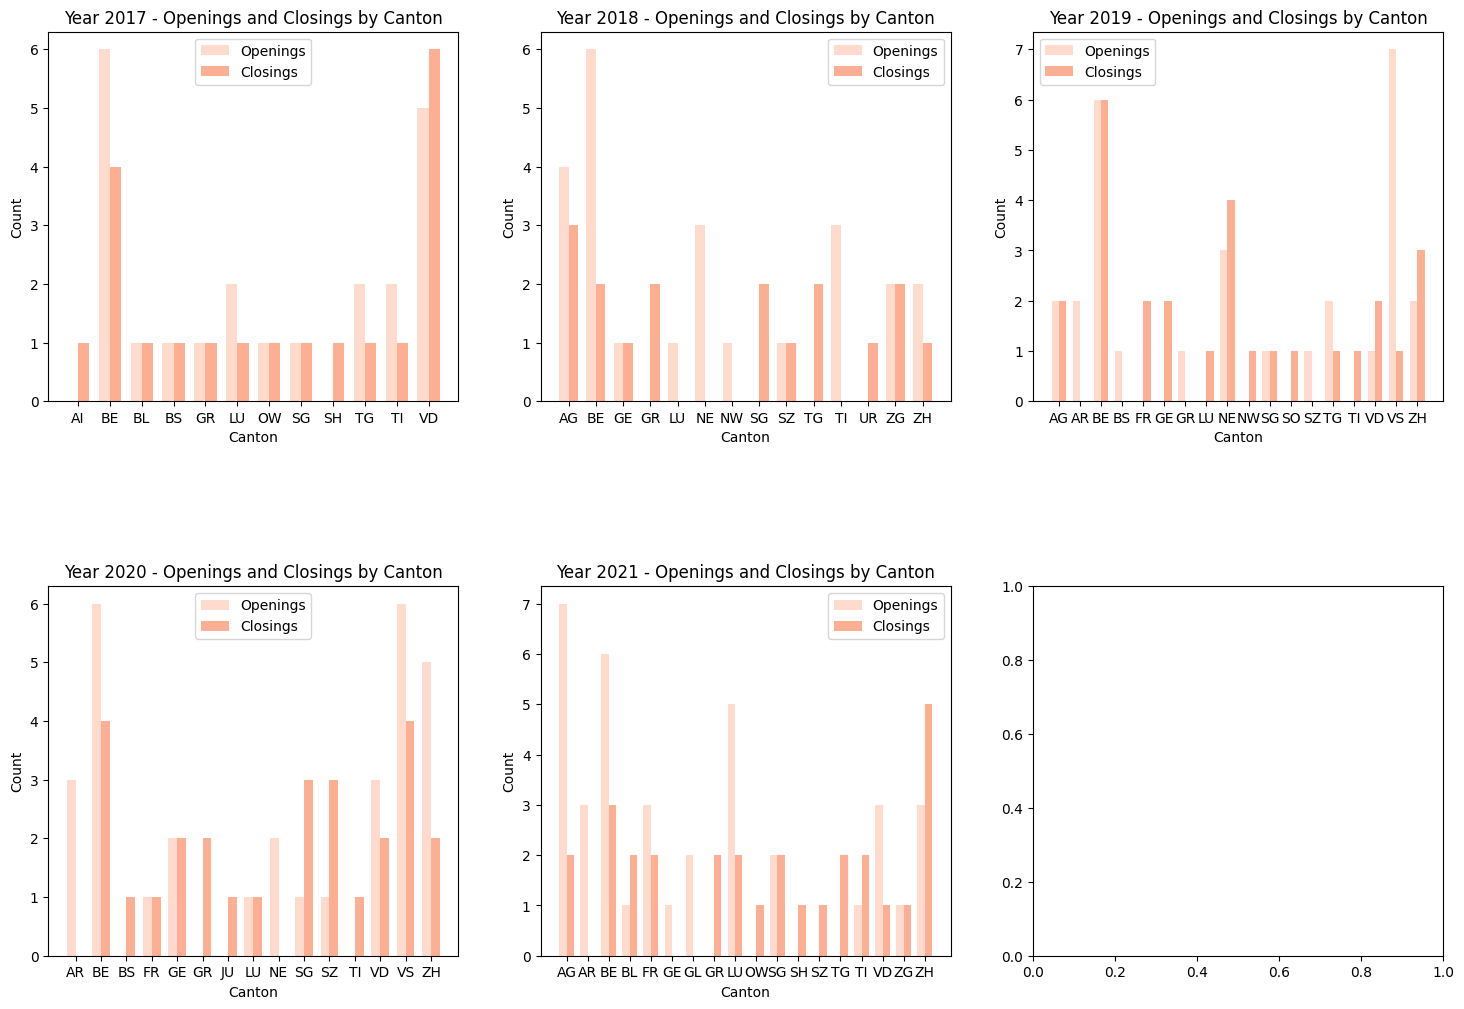

In [170]:
years = df_final['year'].unique()
colors = sns.color_palette("Reds")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5)

for i, year in enumerate(years):
    data_year = df_final[df_final['year'] == year]

    counts_open = data_year[data_year['site_new'] == True].groupby('canr').size()
    counts_closed = data_year[data_year['site_closed'] == True].groupby('canr').size()

    non_zero_cantons = np.union1d(counts_open[counts_open > 0].index, counts_closed[counts_closed > 0].index)

    ax = axes[i // 3, i % 3]  # Select the appropriate subplot

    bar_width = 0.35
    x = np.arange(len(non_zero_cantons))
    ax.bar(x - bar_width/2, counts_open.reindex(non_zero_cantons, fill_value=0), label='Openings', width=bar_width, color=colors[0])
    ax.bar(x + bar_width/2, counts_closed.reindex(non_zero_cantons, fill_value=0), label='Closings', width=bar_width, color=colors[1])

    ax.set_title(f'Year {year} - Openings and Closings by Canton')
    ax.set_xlabel('Canton')
    ax.set_ylabel('Count')
    ax.set_xticks(x)
    ax.set_xticklabels(non_zero_cantons)
    ax.legend()

plt.savefig('my_plot6.png')  # Save the plot as an image file
plt.show()

# Close the plot
plt.close()

In [ ]:
# sites_by_year = df_final.groupby('year')['site_nb_r4'].sum()

# plt.plot(sites_by_year.index, sites_by_year.values, marker='o')
# plt.xlabel('Year')
# plt.ylabel('Number of Sites')
# plt.title('Evolution of Number of Sites over Time')
# plt.show()

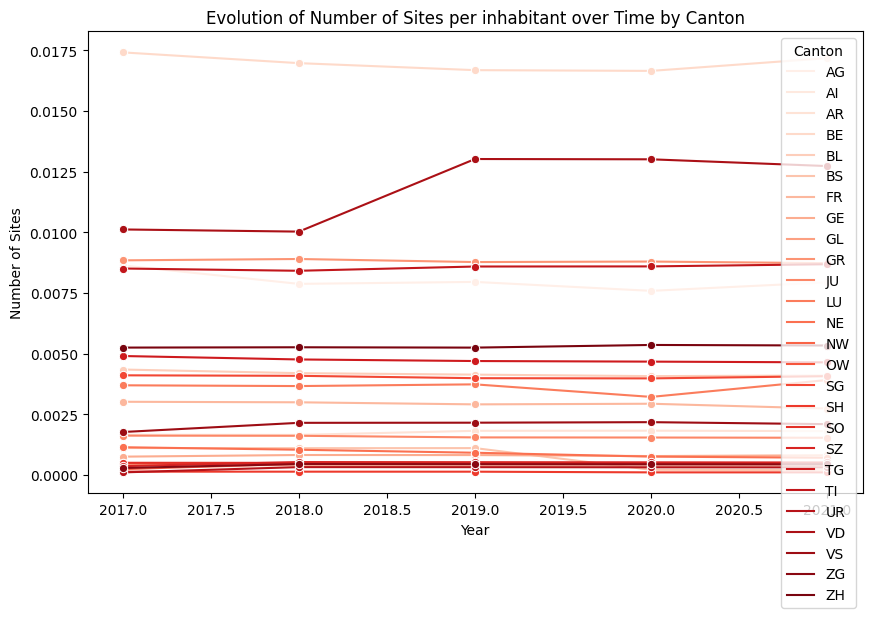

In [297]:
# sites_by_year_canton = df_final.groupby(['year', 'canr'])['site_to_pop'].sum().reset_index()

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=sites_by_year_canton, x='year', y='site_to_pop', hue='canr', palette='Reds', marker='o')
# plt.xlabel('Year')
# plt.ylabel('Number of Sites')
# plt.title('Evolution of Number of Sites per inhabitant over Time by Canton')
# plt.legend(title='Canton')

# plt.show()

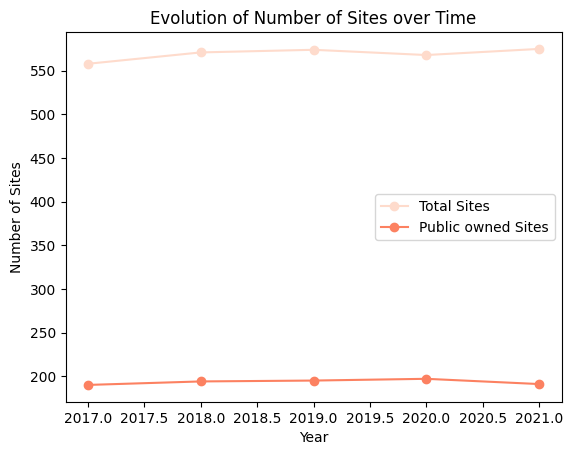

In [286]:
# sites_by_year = df_final.groupby('year')['site_nb'].sum()
# sites_r4_by_year = df_final.groupby('year')['site_nb_r4'].sum()
# colors = sns.color_palette("Reds")

# plt.plot(sites_by_year.index, sites_by_year.values, marker='o', label='Total Sites', color=colors[0])
# plt.plot(sites_r4_by_year.index, sites_r4_by_year.values, marker='o', label='Public owned Sites', color=colors[2])
# plt.xlabel('Year')
# plt.ylabel('Number of Sites')
# plt.title('Evolution of Number of Sites over Time')
# plt.legend()
# plt.show()

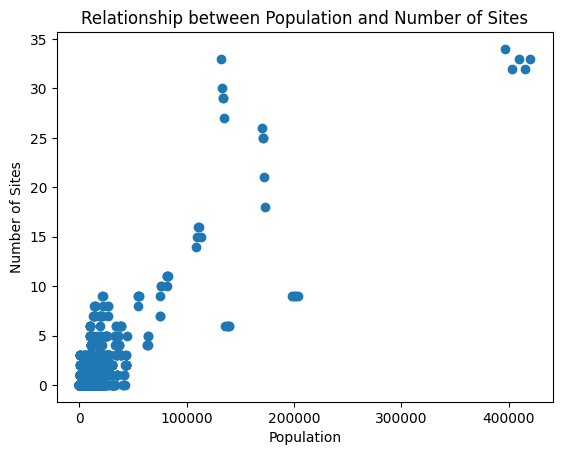

In [322]:
# x = df_final['gd_hab_2bf']
# y = df_final['site_nb']

# plt.scatter(x, y)
# plt.xlabel('Population')
# plt.ylabel('Number of Sites')
# plt.title('Relationship between Population and Number of Sites')
# plt.show()

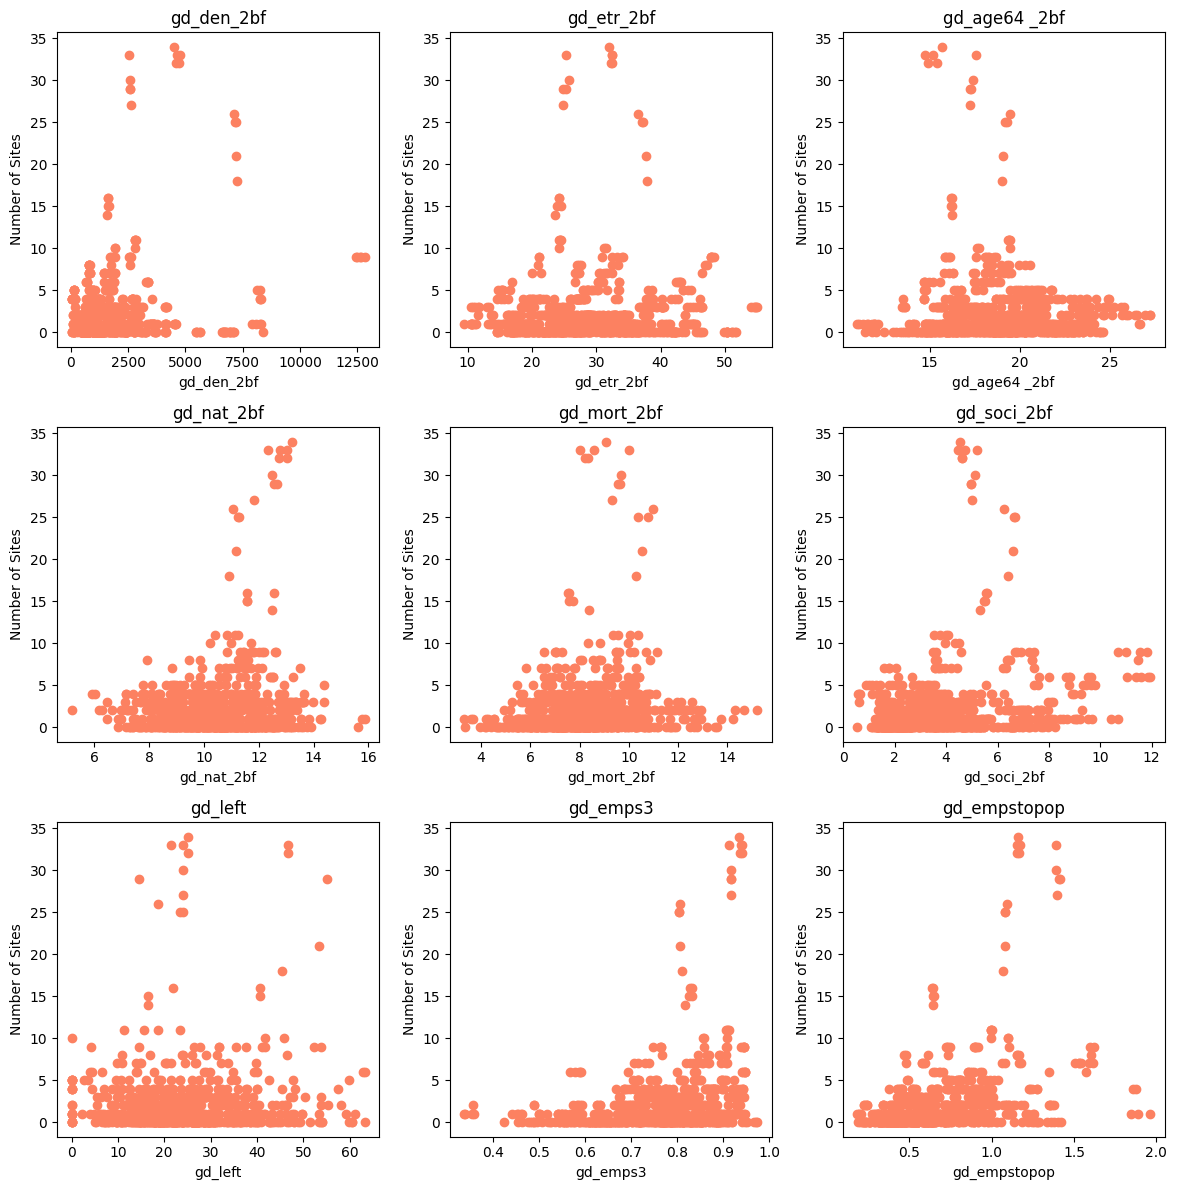

In [300]:
# variables = ['gd_den_2bf', 'gd_etr_2bf', 'gd_age64 _2bf', 'gd_nat_2bf', 'gd_mort_2bf', 'gd_soci_2bf', 'gd_left', 'gd_emps3', 'gd_empstopop']

# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# fig.subplots_adjust(hspace=0.5)

# for i, variable in enumerate(variables):
#     x = df_final.loc[df_final['gd_hab_2bf'] >= 10000, variable]
#     y = df_final.loc[df_final['gd_hab_2bf'] >= 10000, 'site_nb']

#     row = i // 3
#     col = i % 3

#     ax = axes[row, col]
#     ax.scatter(x, y, color=sns.color_palette('Reds')[2])
#     ax.set_xlabel(variable)
#     ax.set_ylabel('Number of Sites')
#     ax.set_title(variable)

# plt.tight_layout()
# plt.show()

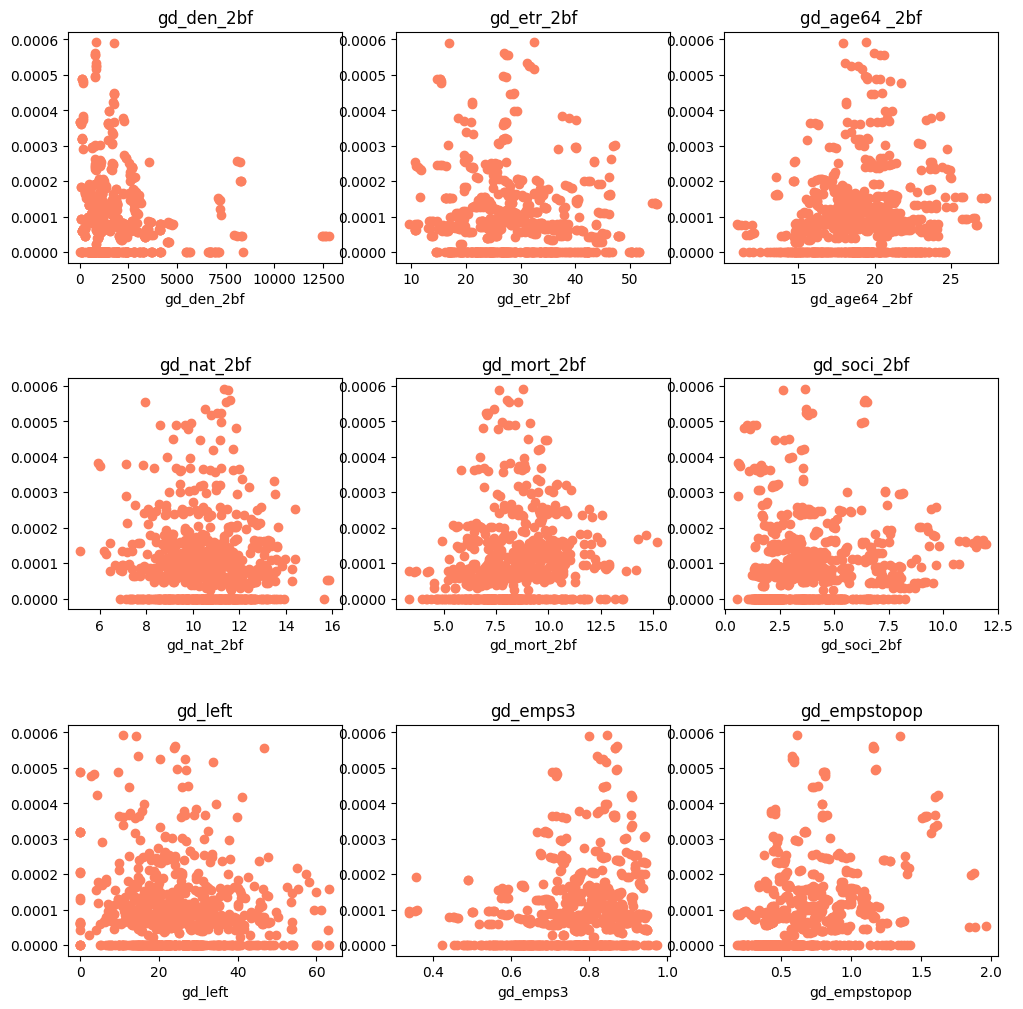

In [174]:
variables = ['gd_den_2bf', 'gd_etr_2bf', 'gd_age64 _2bf', 'gd_nat_2bf', 'gd_mort_2bf', 'gd_soci_2bf', 'gd_left', 'gd_emps3', 'gd_empstopop']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

for i, variable in enumerate(variables):
    x = df_final.loc[df_final['gd_hab_2bf'] >= 10000, variable]
    y = df_final.loc[df_final['gd_hab_2bf'] >= 10000, 'site_to_pop']

    row = i // 3
    col = i % 3

    ax = axes[row, col]
    ax.scatter(x, y, color=sns.color_palette('Reds')[2])
    ax.set_xlabel(variable)
    ax.set_title(variable)

plt.savefig('my_plot7.png')  # Save the plot as an image file
plt.show()

# Close the plot
plt.close()

<ipython-input-302-914ee6e24d03>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_final, x='ct_pol', y='site_nb', palette='Reds')


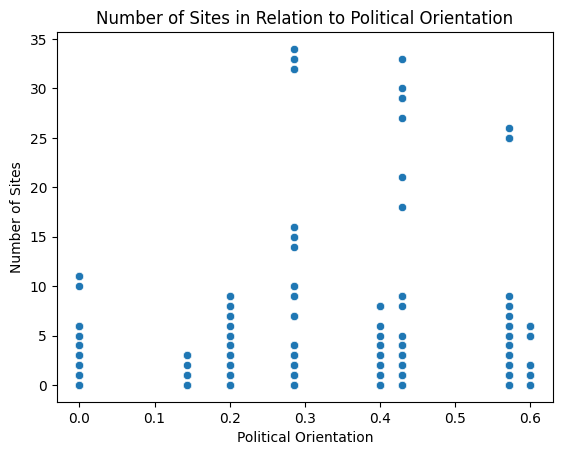

In [302]:
sns.scatterplot(data=df_final, x='ct_pol', y='site_nb', palette='Reds')

plt.xlabel('Political Orientation')
plt.ylabel('Number of Sites')
plt.title('Number of Sites in Relation to the Force of Left Parties in the Government')

plt.show()

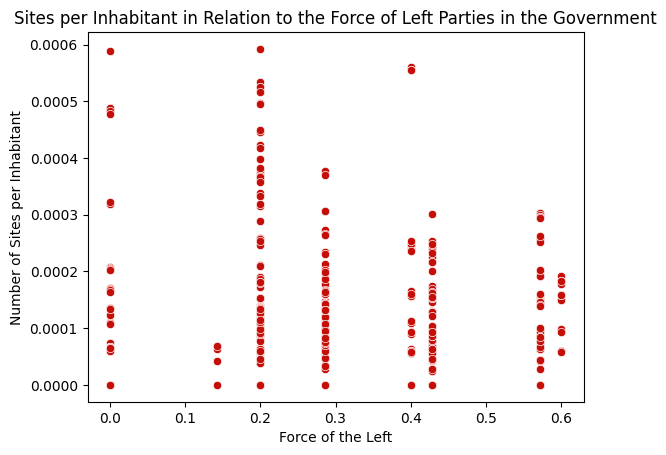

In [177]:
filtered_data = df_final[df_final['gd_hab_2bf'] >= 10000]

sns.scatterplot(data=filtered_data, x='ct_pol', y='site_to_pop', color = "#C60E08")

plt.xlabel('Force of the Left')
plt.ylabel('Number of Sites per Inhabitant')
plt.title('Sites per Inhabitant in Relation to the Force of Left Parties in the Government')
plt.savefig('my_plot8.png')  # Save the plot as an image file
plt.show()

# Close the plot
plt.close()

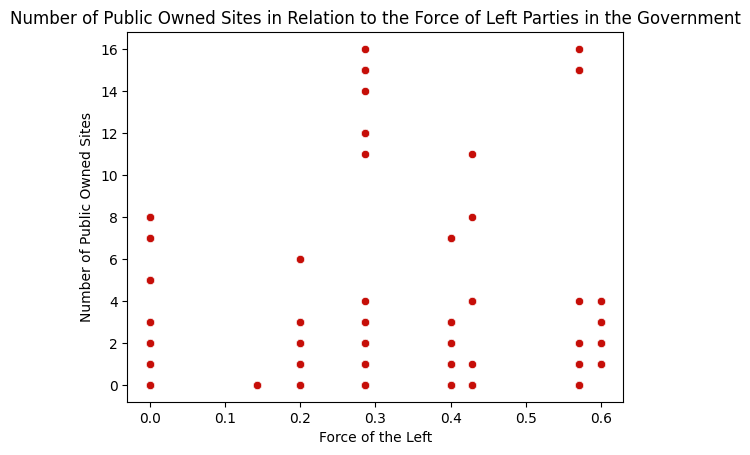

In [317]:
filtered_data = df_final[df_final['gd_hab_2bf'] >= 10000]

sns.scatterplot(data=filtered_data, x='ct_pol', y='site_nb_r4', color = "#C60E08")

plt.xlabel('Force of the Left')
plt.ylabel('Number of Public Owned Sites')
plt.title('Number of Public Owned Sites in Relation to the Force of Left Parties in the Government')

plt.show()

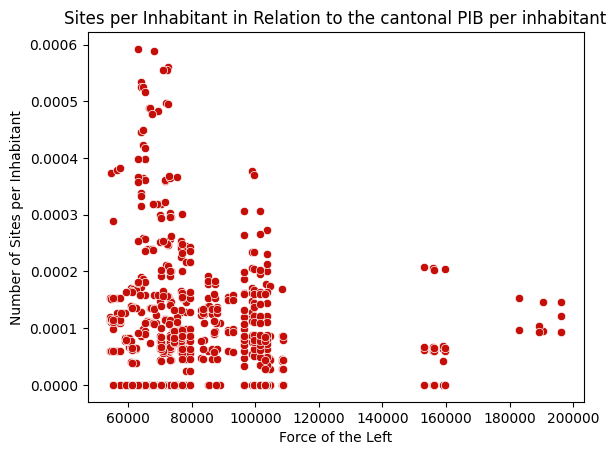

In [178]:
filtered_data = df_final[df_final['gd_hab_2bf'] >= 10000]

sns.scatterplot(data=filtered_data, x='ct_pib1', y='site_to_pop', color = "#C60E08")

plt.xlabel('Force of the Left')
plt.ylabel('Number of Sites per Inhabitant')
plt.title('Sites per Inhabitant in Relation to the cantonal PIB per inhabitant')
plt.savefig('my_plot9.png')  # Save the plot as an image file
plt.show()

plt.close()

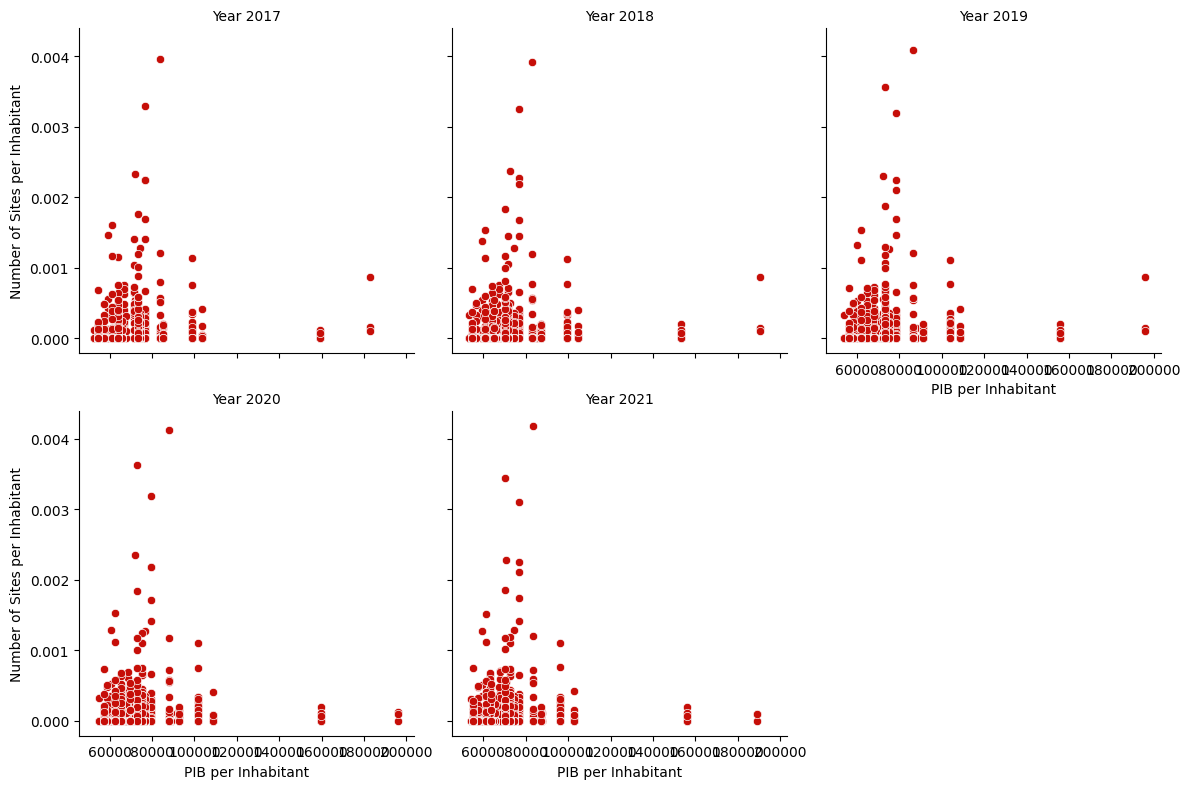

In [319]:
grid = sns.FacetGrid(data=df_final, col='year', col_wrap=3, height=4)

grid.map(sns.scatterplot, 'ct_pib1', 'site_to_pop', color='#C60E08')

grid.set_axis_labels('PIB per Inhabitant', 'Number of Sites per Inhabitant')
grid.set_titles('Year {col_name}')

plt.tight_layout()


plt.show()

# Inferential statistic and Machine learning

###1) Logistic regression

In [180]:
import statsmodels.api as sm

In [181]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [209]:
to_float = ['canr_AI', 'canr_AR',
       'canr_BE', 'canr_BL', 'canr_BS', 'canr_FR', 'canr_GE', 'canr_GL',
       'canr_GR', 'canr_JU', 'canr_LU', 'canr_NE', 'canr_NW', 'canr_OW',
       'canr_SG', 'canr_SH', 'canr_SO', 'canr_SZ', 'canr_TG', 'canr_TI',
       'canr_UR', 'canr_VD', 'canr_VS', 'canr_ZG', 'canr_ZH']

df_final_dropped[to_float] = df_final_dropped[to_float].astype('float')

In [182]:
df_final['site_new'] = df_final['site_new'].replace({True: 1, False: 0})
df_final['site_closed'] = df_final['site_closed'].replace({True: 1, False: 0})

In [183]:
count = df_final['site_new'].value_counts()
print(count)

0    10971
1      144
Name: site_new, dtype: int64


In [184]:
df_final_dropped = df_final.dropna()
df_final_dropped = pd.get_dummies(df_final_dropped, columns=['canr'], drop_first=True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
y_train: Counter({0: 6843, 1: 113}) y_test: Counter({0: 1711, 1: 28})
Accuracy: 0.9838987924094307
train mse = 0.12645286973406927
test mse = 0.12586484300508494
train R2 = 0.9837550316273721
test R2 = 0.9838987924094307


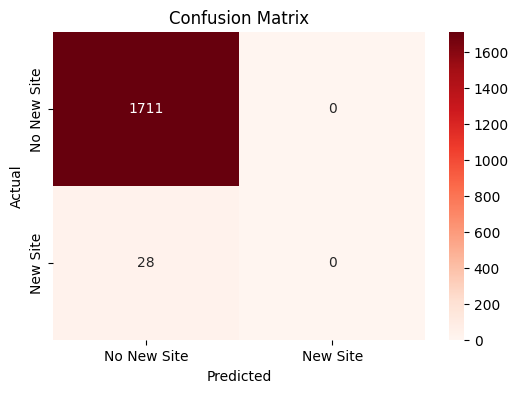

In [267]:
X = df_final_dropped.drop(['site_new'], axis=1)
y = df_final_dropped['site_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert categorical to dummies

model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(model)
print(f'y_train: {Counter(y_train)}', f'y_test: {Counter(y_test)}')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


coefficients = model.coef_[0]
feature_names = X_train.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print('train mse =', np.std(y_train - model.predict(X_train)))
print('test mse =', np.std(y_test - model.predict(X_test)))
print('train R2 =', model.score(X_train, y_train))
print('test R2 =', model.score(X_test, y_test))

labels = ['No New Site', 'New Site']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


y_train: Counter({0: 6862, 1: 94}) y_test: Counter({0: 1716, 1: 23})
Accuracy: 0.9867740080506038
train mse = 0.11609704564489107
test mse = 0.11424125824915758
train R2 = 0.9863427257044278
test R2 = 0.9867740080506038


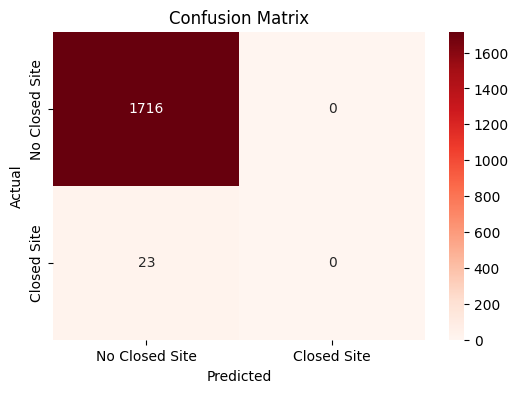

In [200]:
X = df_final_dropped.drop(['site_closed'], axis=1)
y = df_final_dropped['site_closed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


model2 = LogisticRegression()
model2.fit(X_train, y_train)


y_pred = model2.predict(X_test)

print(f'y_train: {Counter(y_train)}', f'y_test: {Counter(y_test)}')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print('train mse =', np.std(y_train - model2.predict(X_train)))
print('test mse =', np.std(y_test - model2.predict(X_test)))
print('train R2 =', model2.score(X_train, y_train))
print('test R2 =', model2.score(X_test, y_test))

labels = ['No Closed Site', 'Closed Site']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##2) Boosted tree

In [237]:
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.metrics import classification_report

y_train: Counter({0: 6862, 1: 94}) y_test: Counter({0: 1716, 1: 23})
training score : 0.986 (n_est=1)
test score : 0.987 (n_est=1)
GradientBoostingClassifier(max_depth=1, n_estimators=1, subsample=0.5)


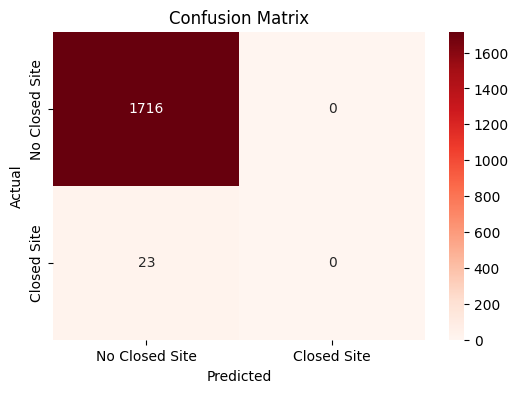

y_train: Counter({0: 6862, 1: 94}) y_test: Counter({0: 1716, 1: 23})
training score : 0.986 (n_est=4)
test score : 0.987 (n_est=4)
GradientBoostingClassifier(max_depth=1, n_estimators=4, subsample=0.5)


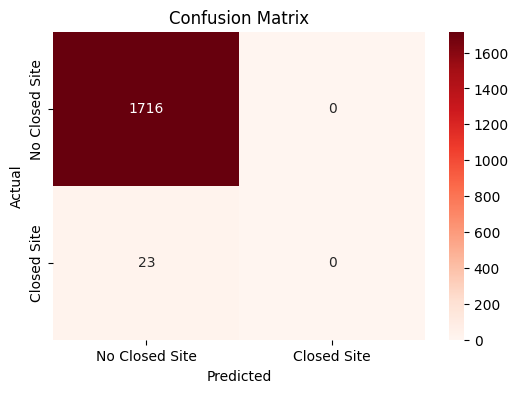

y_train: Counter({0: 6862, 1: 94}) y_test: Counter({0: 1716, 1: 23})
training score : 0.987 (n_est=50)
test score : 0.986 (n_est=50)
GradientBoostingClassifier(max_depth=1, n_estimators=50, subsample=0.5)


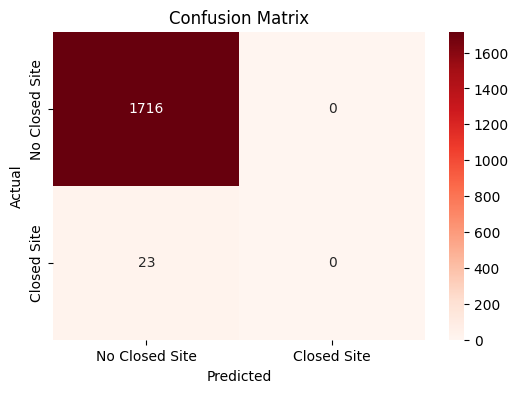

In [201]:
X = df_final_dropped.drop(['site_closed'], axis=1)
y = df_final_dropped['site_closed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

for n_est in (1, 4, 50):
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=n_est,
                                              learning_rate=0.1, subsample=0.5)
    dtc.fit(X_train, y_train)

    print(f'y_train: {Counter(y_train)}', f'y_test: {Counter(y_test)}')
    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X_train, y_train), n_est))
    # print the test scores
    print("test score : %.3f (n_est=%d)" % (dtc.score(X_test, y_test), n_est))
    print(dtc)
    labels = ['No Closed Site', 'Closed Site']

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

##3) Trying to solve the imbalance problem

###First by undersampling

In [202]:
#Deleting all municipalities where inhabitants < 10'000
df_filtered = df_final_dropped[df_final_dropped['gd_hab_2bf'] >= 10000]

y_train: Counter({0: 562, 1: 52}) y_test: Counter({0: 141, 1: 13})
training score : 0.915 (n_est=1)
test score : 0.916 (n_est=1)
GradientBoostingClassifier(max_depth=1, n_estimators=1, subsample=0.5)


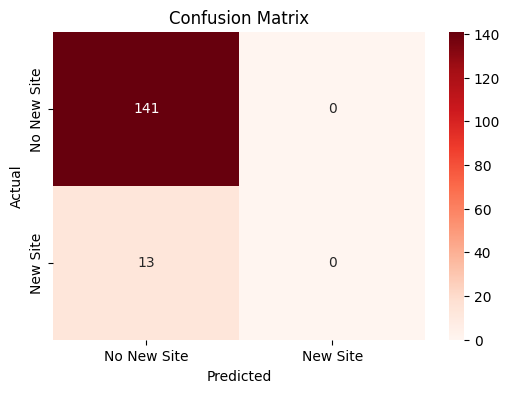

y_train: Counter({0: 562, 1: 52}) y_test: Counter({0: 141, 1: 13})
training score : 0.915 (n_est=4)
test score : 0.916 (n_est=4)
GradientBoostingClassifier(max_depth=1, n_estimators=4, subsample=0.5)


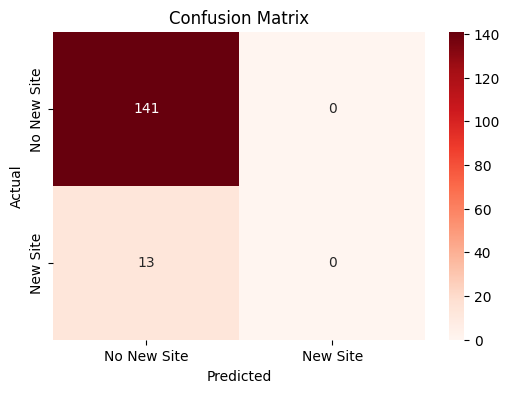

y_train: Counter({0: 562, 1: 52}) y_test: Counter({0: 141, 1: 13})
training score : 0.923 (n_est=50)
test score : 0.922 (n_est=50)
GradientBoostingClassifier(max_depth=1, n_estimators=50, subsample=0.5)


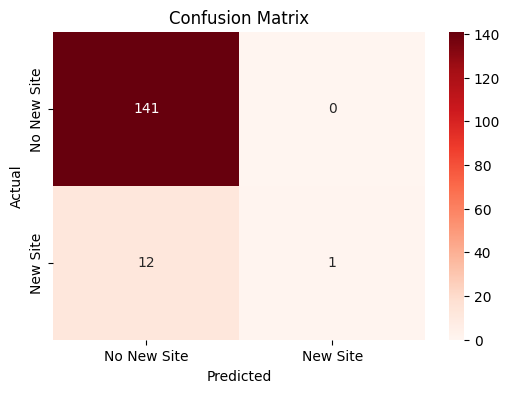

In [204]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

for n_est in (1, 4, 50):
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=n_est,
                                              learning_rate=0.1, subsample=0.5)
    dtc.fit(X_train, y_train)

    print(f'y_train: {Counter(y_train)}', f'y_test: {Counter(y_test)}')
    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X_train, y_train), n_est))
    # print the test scores
    print("test score : %.3f (n_est=%d)" % (dtc.score(X_test, y_test), n_est))
    print(dtc)

    y_pred = dtc.predict(X_test)
    labels = ['No New Site', 'New Site']

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [195]:
tp_observations = X_test[(y_pred == 1) & (y_test == 1)]

# Print the observations
print("True Positives (TP) Observations:")
print(tp_observations)

True Positives (TP) Observations:
      gdenr  gd_hab_2bf  gd_den_2bf  gd_etr_2bf  gd_age64 _2bf  gd_nat_2bf  \
6535   6136       18174      726.96   31.759657      16.831738   10.837112   

      gd_mort_2bf  gd_lovac_3bf  gd_locon_3bf  gd_soci_2bf  ...  canr_SH  \
6535      9.17837       2.77394      15.23993     3.350372  ...        0   

      canr_SO  canr_SZ  canr_TG  canr_TI  canr_UR  canr_VD  canr_VS  canr_ZG  \
6535        0        0        0        0        0        0        1        0   

      canr_ZH  
6535        0  

[1 rows x 48 columns]


In [205]:
#Trying to find the best estimators
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {'n_estimators': [10, 50, 100, 200]}

model = ensemble.GradientBoostingClassifier(max_depth=1, learning_rate=0.1, subsample=0.5)

grid_search = GridSearchCV(model, param_grid, cv=5)


grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_n_estimators = best_model.n_estimators_


print("Best n_estimators:", best_n_estimators)

Best n_estimators: 10


GradientBoostingClassifier(max_depth=1, n_estimators=10, subsample=0.5)
y_train: Counter({0: 562, 1: 52}) y_test: Counter({0: 141, 1: 13})
training score : 0.919 (n_est=10)
test score : 0.922 (n_est=10)


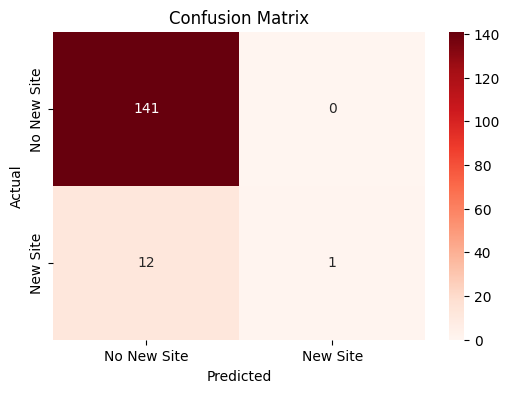

In [269]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

best_n_estimators = 10

final_model = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=best_n_estimators,
                                                  learning_rate=0.1, subsample=0.5)

final_model.fit(X_train, y_train)

accuracy = final_model.score(X_test, y_test)

print(final_model)
print(f'y_train: {Counter(y_train)}', f'y_test: {Counter(y_test)}')
# print the training scores
print("training score : %.3f (n_est=%d)" % (final_model.score(X_train, y_train), best_n_estimators))
# print the test scores
print("test score : %.3f (n_est=%d)" % (final_model.score(X_test, y_test), best_n_estimators))

y_pred = final_model.predict(X_test)  # Predict using the final model

labels = ['No New Site', 'New Site']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Now by oversampling: with full dataset

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from numpy.random import RandomState
from imblearn.over_sampling import ADASYN
from collections import Counter

In [270]:
X = df_final_dropped.drop(['site_new'], axis=1)
y = df_final_dropped['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print("test estimators")
for n_est in (1, 4, 10, 30, 50, 60):
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=n_est,
                                              learning_rate=0.05, subsample=0.5)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X_train_resampled, y_train_resampled), n_est))
    # print the test scores
    print("test score : %.3f (n_est=%d)" % (dtc.score(X_test, y_test), n_est))

test estimators
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=1,
                           subsample=0.5)
training score : 0.936 (n_est=1)
test score : 0.884 (n_est=1)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=4,
                           subsample=0.5)
training score : 0.936 (n_est=4)
test score : 0.884 (n_est=4)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=10,
                           subsample=0.5)
training score : 0.936 (n_est=10)
test score : 0.884 (n_est=10)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=30,
                           subsample=0.5)
training score : 0.936 (n_est=30)
test score : 0.884 (n_est=30)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=50,
                           subsample=0.5)
training score : 0.937 (n_est=50)
test score : 0.884 (n_est=50)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=60

In [271]:
X = df_final_dropped.drop(['site_new'], axis=1)
y = df_final_dropped['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

n_est = 60

max_depths = [1, 2, 3, 4, 5]
print("test depth")

for max_depth in max_depths:
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_est,
                                              learning_rate=0.05, subsample=0.5)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (max_depth=%d)" % (dtc.score(X_train_resampled, y_train_resampled), max_depth))
    # print the test scores
    print("test score : %.3f (max_depth=%d)" % (dtc.score(X_test, y_test), max_depth))

test depth
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=60,
                           subsample=0.5)
training score : 0.937 (max_depth=1)
test score : 0.884 (max_depth=1)
GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=60,
                           subsample=0.5)
training score : 0.945 (max_depth=2)
test score : 0.893 (max_depth=2)
GradientBoostingClassifier(learning_rate=0.05, n_estimators=60, subsample=0.5)
training score : 0.955 (max_depth=3)
test score : 0.908 (max_depth=3)
GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=60,
                           subsample=0.5)
training score : 0.963 (max_depth=4)
test score : 0.922 (max_depth=4)
GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=60,
                           subsample=0.5)
training score : 0.970 (max_depth=5)
test score : 0.936 (max_depth=5)


In [272]:
X = df_final_dropped.drop(['site_new'], axis=1)
y = df_final_dropped['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

n_est = 60

learning_rates = [0.05, 0.01, 0.1]
print("test learning rates")

for learning_rate in learning_rates:
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=n_est,
                                              learning_rate=learning_rate, subsample=0.5)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (learning_rate=%.2f)" % (dtc.score(X_train_resampled, y_train_resampled), learning_rate))
    # print the test scores
    print("test score : %.3f (learning_rate=%.2f)" % (dtc.score(X_test, y_test), learning_rate))

test learning rates
GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=60,
                           subsample=0.5)
training score : 0.970 (learning_rate=0.05)
test score : 0.932 (learning_rate=0.05)
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=60,
                           subsample=0.5)
training score : 0.957 (learning_rate=0.01)
test score : 0.915 (learning_rate=0.01)
GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.5)
training score : 0.986 (learning_rate=0.10)
test score : 0.954 (learning_rate=0.10)


In [273]:
X = df_final_dropped.drop(['site_new'], axis=1)
y = df_final_dropped['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


subsamples = [0.5, 0.2, 0.1]
print("test subsamples")

for subsample in subsamples:
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=n_est,
                                              learning_rate=0.1, subsample=subsample)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (subsample=%.2f)" % (dtc.score(X_train_resampled, y_train_resampled), subsample))
    # print the test scores
    print("test score : %.3f (subsample=%.2f)" % (dtc.score(X_test, y_test), subsample))

test subsamples
GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.5)
training score : 0.988 (subsample=0.50)
test score : 0.960 (subsample=0.50)
GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.2)
training score : 0.983 (subsample=0.20)
test score : 0.952 (subsample=0.20)
GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.1)
training score : 0.975 (subsample=0.10)
test score : 0.941 (subsample=0.10)


GradientBoostingClassifier(max_depth=5, n_estimators=1, subsample=0.5)
Original: Counter({0: 8554, 1: 141})
train: Counter({0: 6843, 1: 113})
resampled: Counter({0: 6843, 1: 6820})
training score : 0.955
test score : 0.914
              precision    recall  f1-score   support

 No New Site       1.00      0.91      0.95      1711
    New Site       0.15      0.89      0.25        28

    accuracy                           0.91      1739
   macro avg       0.57      0.90      0.60      1739
weighted avg       0.98      0.91      0.94      1739



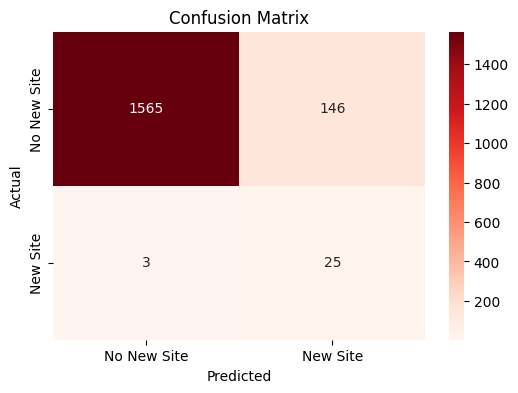

In [250]:
X = df_final_dropped.drop(['site_new'], axis=1)
y = df_final_dropped['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# do fit
dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=1, learning_rate=0.1, subsample=0.5)
dtc.fit(X_train_resampled, y_train_resampled)
y_pred = dtc.predict(X_test)  # Use dtc for predictions

labels = ['No New Site', 'New Site']

print(dtc)
print(f'Original: {Counter(y)}')
print(f'train: {Counter(y_train)}')
print(f'resampled: {Counter(y_train_resampled)}')
# print the training scores
print("training score : %.3f" % dtc.score(X_train_resampled, y_train_resampled))
# print the test scores
print("test score : %.3f" % dtc.score(X_test, y_test))
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

GradientBoostingClassifier(max_depth=5, n_estimators=1, subsample=0.5)
Original: Counter({0: 8578, 1: 117})
train: Counter({0: 6862, 1: 94})
resampled: Counter({0: 6862, 1: 6845})
training score : 0.953
test score : 0.905
                precision    recall  f1-score   support

No Closed Site       1.00      0.91      0.95      1716
   Closed Site       0.11      0.83      0.19        23

      accuracy                           0.91      1739
     macro avg       0.55      0.87      0.57      1739
  weighted avg       0.99      0.91      0.94      1739



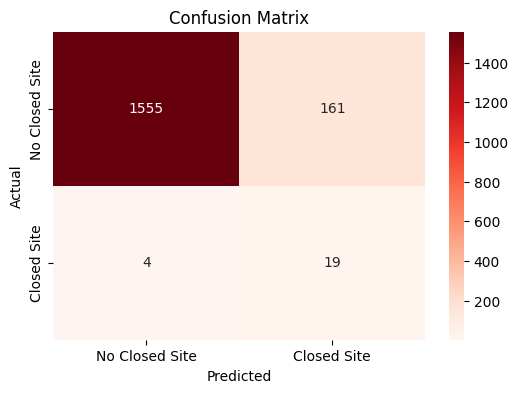

In [252]:
X = df_final_dropped.drop(['site_closed'], axis=1)
y = df_final_dropped['site_closed']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# do fit
dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=1, learning_rate=0.1, subsample=0.5)
dtc.fit(X_train_resampled, y_train_resampled)
y_pred = dtc.predict(X_test)  # Use dtc for predictions

labels = ['No Closed Site', 'Closed Site']

print(dtc)
print(f'Original: {Counter(y)}')
print(f'train: {Counter(y_train)}')
print(f'resampled: {Counter(y_train_resampled)}')
# print the training scores
print("training score : %.3f" % dtc.score(X_train_resampled, y_train_resampled))
# print the test scores
print("test score : %.3f" % dtc.score(X_test, y_test))
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Now by oversampling: with reduced dataset

In [220]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

for n_est in (1, 4, 10, 30, 50, 60):
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=1, n_estimators=n_est,
                                              learning_rate=0.05, subsample=0.5)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (n_est=%d)" % (dtc.score(X_train_resampled, y_train_resampled), n_est))
    # print the test scores
    print("test score : %.3f (n_est=%d)" % (dtc.score(X_test, y_test), n_est))

GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=1,
                           subsample=0.5)
training score : 0.760 (n_est=1)
test score : 0.617 (n_est=1)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=4,
                           subsample=0.5)
training score : 0.760 (n_est=4)
test score : 0.617 (n_est=4)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=10,
                           subsample=0.5)
training score : 0.760 (n_est=10)
test score : 0.617 (n_est=10)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=30,
                           subsample=0.5)
training score : 0.775 (n_est=30)
test score : 0.617 (n_est=30)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=50,
                           subsample=0.5)
training score : 0.822 (n_est=50)
test score : 0.721 (n_est=50)
GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=60,
              

In [223]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

n_est = 60

max_depths = [1, 2, 3, 4, 5]

for max_depth in max_depths:
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_est,
                                              learning_rate=0.05, subsample=0.5)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (max_depth=%d)" % (dtc.score(X_train_resampled, y_train_resampled), max_depth))
    # print the test scores
    print("test score : %.3f (max_depth=%d)" % (dtc.score(X_test, y_test), max_depth))

GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=60,
                           subsample=0.5)
training score : 0.832 (max_depth=1)
test score : 0.727 (max_depth=1)
GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=60,
                           subsample=0.5)
training score : 0.879 (max_depth=2)
test score : 0.753 (max_depth=2)
GradientBoostingClassifier(learning_rate=0.05, n_estimators=60, subsample=0.5)
training score : 0.928 (max_depth=3)
test score : 0.786 (max_depth=3)
GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=60,
                           subsample=0.5)
training score : 0.961 (max_depth=4)
test score : 0.838 (max_depth=4)
GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=60,
                           subsample=0.5)
training score : 0.981 (max_depth=5)
test score : 0.857 (max_depth=5)


In [225]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

n_est = 60

learning_rates = [0.05, 0.01, 0.1]

for learning_rate in learning_rates:
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=n_est,
                                              learning_rate=learning_rate, subsample=0.5)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (learning_rate=%.2f)" % (dtc.score(X_train_resampled, y_train_resampled), learning_rate))
    # print the test scores
    print("test score : %.3f (learning_rate=%.2f)" % (dtc.score(X_test, y_test), learning_rate))

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=60,
                           subsample=0.5)
training score : 0.982 (learning_rate=0.05)
test score : 0.864 (learning_rate=0.05)
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=60,
                           subsample=0.5)
training score : 0.910 (learning_rate=0.01)
test score : 0.805 (learning_rate=0.01)
GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.5)
training score : 0.994 (learning_rate=0.10)
test score : 0.877 (learning_rate=0.10)


In [227]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


subsamples = [0.5, 0.2, 0.1]

for subsample in subsamples:
    # do fit
    dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=n_est,
                                              learning_rate=0.1, subsample=subsample)
    dtc.fit(X_train_resampled, y_train_resampled)
    print(dtc)
    # print the training scores
    print("training score : %.3f (subsample=%.2f)" % (dtc.score(X_train_resampled, y_train_resampled), subsample))
    # print the test scores
    print("test score : %.3f (subsample=%.2f)" % (dtc.score(X_test, y_test), subsample))

GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.5)
training score : 0.997 (subsample=0.50)
test score : 0.883 (subsample=0.50)
GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.2)
training score : 0.974 (subsample=0.20)
test score : 0.831 (subsample=0.20)
GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.1)
training score : 0.946 (subsample=0.10)
test score : 0.825 (subsample=0.10)


GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.5)
Original: Counter({0: 703, 1: 65}) train: Counter({0: 562, 1: 52}) resampled: Counter({0: 562, 1: 560})
training score : 0.996 (n_est=60)
test score : 0.903 (n_est=60)
              precision    recall  f1-score   support

 No New Site       0.95      0.94      0.95       141
    New Site       0.43      0.46      0.44        13

    accuracy                           0.90       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.91      0.90      0.90       154



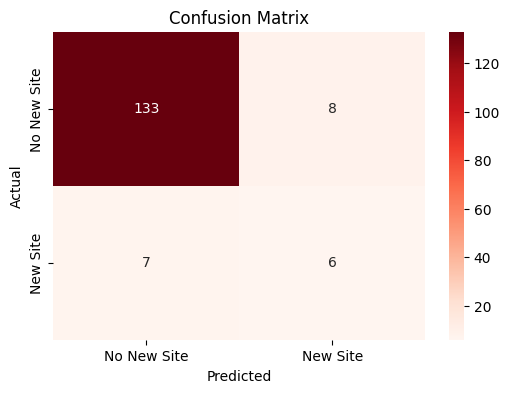

In [243]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


# do fit
dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=60, learning_rate=0.1, subsample=0.5)
dtc.fit(X_train_resampled, y_train_resampled)
y_pred = dtc.predict(X_test)  # Use dtc for predictions
labels = ['No New Site', 'New Site']

print(dtc)
print(f'Original: {Counter(y)}', f'train: {Counter(y_train)}',f'resampled: {Counter(y_train_resampled)}')
# print the training scores
print("training score : %.3f (n_est=%d)" % (dtc.score(X_train_resampled, y_train_resampled), n_est))
# print the test scores
print("test score : %.3f (n_est=%d)" % (dtc.score(X_test, y_test), n_est))




report = classification_report(y_test, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.5)
Original: Counter({0: 703, 1: 65}) train: Counter({0: 572, 1: 42}) resampled: Counter({0: 572, 1: 570})
training score : 0.998 (n_est=60)
test score : 0.909 (n_est=60)
              precision    recall  f1-score   support

 No New Site       0.95      0.96      0.95       144
    New Site       0.25      0.20      0.22        10

    accuracy                           0.91       154
   macro avg       0.60      0.58      0.59       154
weighted avg       0.90      0.91      0.90       154



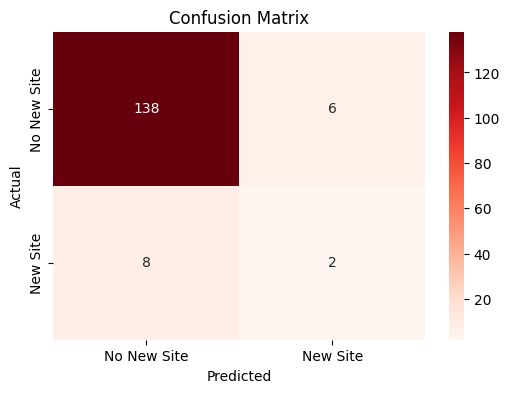

In [248]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X = X.astype('float')

smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


# do fit
dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=60, learning_rate=0.1, subsample=0.5)
dtc.fit(X_train_resampled, y_train_resampled)
y_pred = dtc.predict(X_test)  # Use dtc for predictions
labels = ['No New Site', 'New Site']

print(dtc)
print(f'Original: {Counter(y)}', f'train: {Counter(y_train)}',f'resampled: {Counter(y_train_resampled)}')
# print the training scores
print("training score : %.3f (n_est=%d)" % (dtc.score(X_train_resampled, y_train_resampled), n_est))
# print the test scores
print("test score : %.3f (n_est=%d)" % (dtc.score(X_test, y_test), n_est))




report = classification_report(y_test, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

GradientBoostingClassifier(max_depth=5, n_estimators=60, subsample=0.5)
Original: Counter({0: 716, 1: 52}) train: Counter({0: 572, 1: 42}) resampled: Counter({0: 572, 1: 570})
training score : 1.000 (n_est=60)
test score : 0.896 (n_est=60)
                precision    recall  f1-score   support

No Closed Site       0.94      0.95      0.94       144
   Closed Site       0.12      0.10      0.11        10

      accuracy                           0.90       154
     macro avg       0.53      0.53      0.53       154
  weighted avg       0.89      0.90      0.89       154



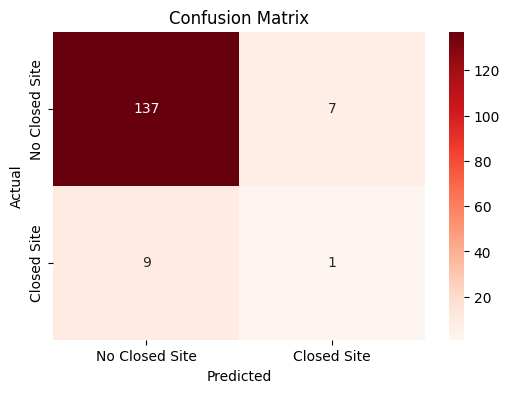

In [247]:
X = df_filtered.drop(['site_closed'], axis=1)
y = df_filtered['site_closed']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


# do fit
dtc = ensemble.GradientBoostingClassifier(max_depth=5, n_estimators=60, learning_rate=0.1, subsample=0.5)
dtc.fit(X_train_resampled, y_train_resampled)
y_pred = dtc.predict(X_test)  # Use dtc for predictions
labels = ['No Closed Site', 'Closed Site']

print(dtc)
print(f'Original: {Counter(y)}', f'train: {Counter(y_train)}',f'resampled: {Counter(y_train_resampled)}')
# print the training scores
print("training score : %.3f (n_est=%d)" % (dtc.score(X_train_resampled, y_train_resampled), n_est))
# print the test scores
print("test score : %.3f (n_est=%d)" % (dtc.score(X_test, y_test), n_est))




report = classification_report(y_test, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##4) Testing some neural networks models



In [253]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [254]:
X = df_final_dropped.drop(['site_closed'], axis=1)
y = df_final_dropped['site_closed']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
print(f'Original: {Counter(y)}', f'train: {Counter(y_train)}',f'resampled: {Counter(y_train_resampled)}')
print(f'x shape: {X_train_resampled.shape}')
print(f'x shape: {y_train_resampled.shape}')

Original: Counter({0: 8578, 1: 117}) train: Counter({0: 6862, 1: 94}) resampled: Counter({0: 6862, 1: 6845})
x shape: (13707, 48)
x shape: (13707,)


In [255]:
model = Sequential()

model.add(Dense(units=16, activation='softmax', input_shape=(48,))) #input layer
model.add(Dense(units=8, activation='softmax'))  #hidden layer
model.add(Dense(units=1, activation='sigmoid')) #output layer

optimizer =tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #optimizer: Adam or rmsprop

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
138/138 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6913 - val_accuracy: 0.9868
Epoch 2/50
138/138 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6889 - val_accuracy: 0.9868
Epoch 3/50
138/138 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6894 - val_accuracy: 0.9868
Epoch 4/50
138/138 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6909 - val_accuracy: 0.9868
Epoch 5/50
138/138 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6906 - val_accuracy: 0.9868
Epoch 6/50
138/138 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6904 - val_accuracy: 0.9868
Epoch 7/50
138/138 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6922 - val_accuracy: 0.9868
Epoch 

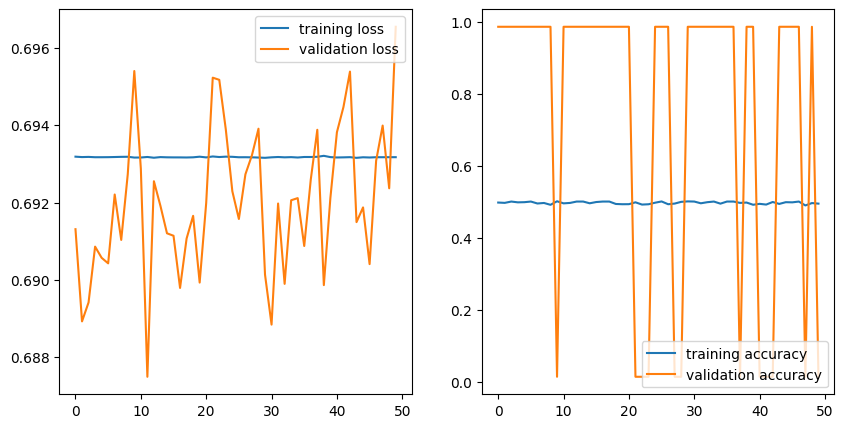

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None


In [260]:
hist = model.fit(X_train_resampled, y_train_resampled, batch_size=100, epochs=50, validation_data=(X_test, y_test))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()
print(model.summary())

Epoch 1/30
138/138 [==============================] - 1s 10ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6930 - val_accuracy: 0.9868
Epoch 2/30
138/138 [==============================] - 1s 7ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6957 - val_accuracy: 0.0132
Epoch 3/30
138/138 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6959 - val_accuracy: 0.0132
Epoch 4/30
138/138 [==============================] - 1s 10ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.9868
Epoch 5/30
138/138 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.4949 - val_loss: 0.6933 - val_accuracy: 0.0132
Epoch 6/30
138/138 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6925 - val_accuracy: 0.9868
Epoch 7/30
138/138 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6911 - val_accuracy: 0.9868
Epoc

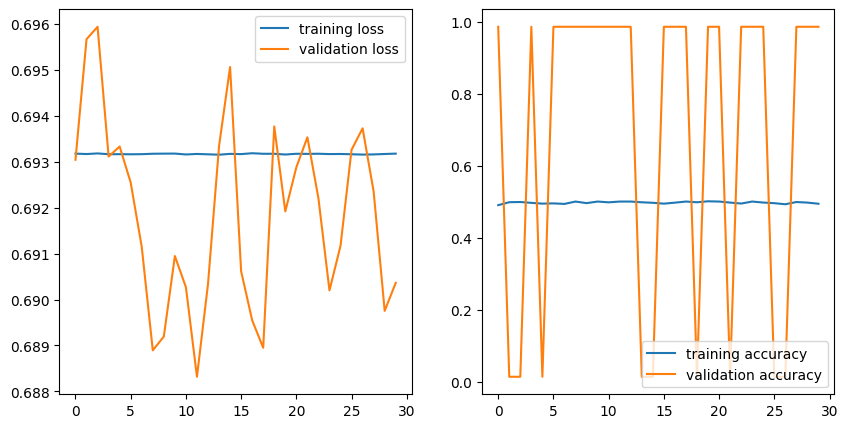

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None


In [261]:
hist = model.fit(X_train_resampled, y_train_resampled, batch_size=100, epochs=30, validation_data=(X_test, y_test))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()
print(model.summary())

In [258]:
model2 = Sequential()

model2.add(Dense(units=16, activation='softmax', input_shape=(48,))) #input layer
#model2.add(Dense(units=8, activation='softmax'))  #hidden layer
model2.add(Dense(units=1, activation='sigmoid')) #output layer

optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #optimizer: Adam or rmsprop

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                784       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
138/138 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.5006 - val_loss: 0.6852 - val_accuracy: 0.9868
Epoch 2/30
138/138 [==============================] - 1s 5ms/step - loss: 0.6943 - accuracy: 0.5006 - val_loss: 0.6855 - val_accuracy: 0.9868
Epoch 3/30
138/138 [==============================] - 1s 6ms/step - loss: 0.6942 - accuracy: 0.5006 - val_loss: 0.6858 - val_accuracy: 0.9868
Epoch 4/30
138/138 [==============================] - 1s 4ms/step - loss: 0.6941 - accuracy: 0.5006 - val_loss: 0.6858 - val_accuracy: 0.9868
Epoch 5/30
138/138 [==============================] - 1s 5ms/step - loss: 0.6941 - accuracy: 0.5006 - val_loss: 0.6858 - val_accuracy: 0.9868
Epoch 6/30
138/138 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.5006 - val_loss: 0.6858 - val_accuracy: 0.9868
Epoch 7/30
138/138 [==============================] - 1s 5ms/step - loss: 0.6940 - accuracy: 0.5006 - val_loss: 0.6856 - val_accuracy: 0.9868
Epoch

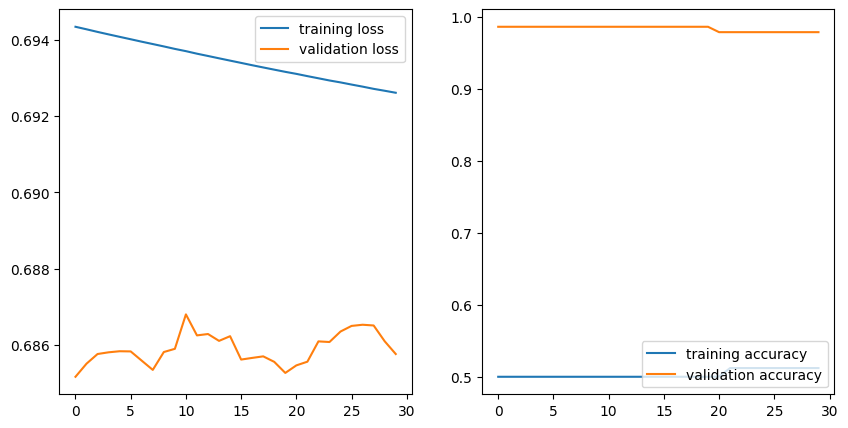

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                784       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
None


In [262]:
hist = model2.fit(X_train_resampled, y_train_resampled, batch_size=100, epochs=30, validation_data=(X_test, y_test))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()
print(model2.summary())

##5) Testing feature importance

In [263]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [264]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestRegressor(n_estimators=150)

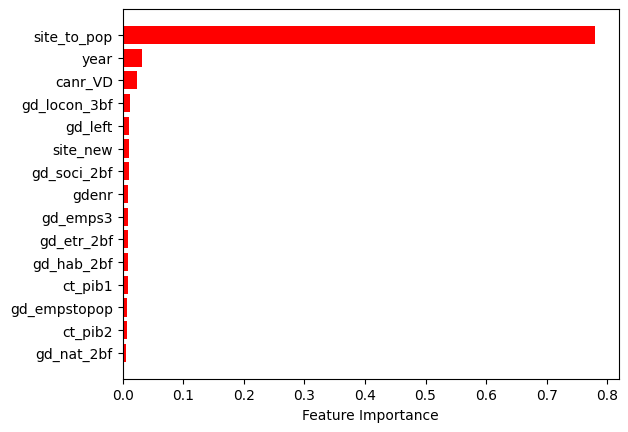

In [265]:
sort = rf.feature_importances_.argsort()
top_15_features = sort[-15:]  # Get the indices of the 15 most important features
plt.barh(X_test.columns[top_15_features], rf.feature_importances_[top_15_features], color='red')
plt.xlabel("Feature Importance")
plt.show()

Original: Counter({0: 716, 1: 52}) train: Counter({0: 572, 1: 42}) resampled: Counter({0: 572, 1: 570})
x shape: (1142, 48)
x shape: (1142,)


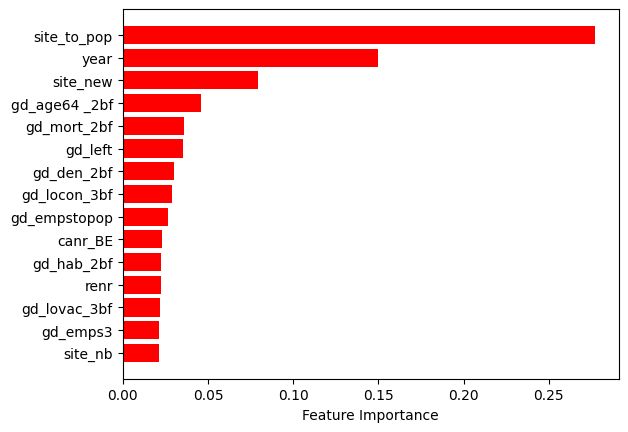

In [266]:
X = df_filtered.drop(['site_closed'], axis=1)
y = df_filtered['site_closed']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
print(f'Original: {Counter(y)}', f'train: {Counter(y_train)}',f'resampled: {Counter(y_train_resampled)}')
print(f'x shape: {X_train_resampled.shape}')
print(f'x shape: {y_train_resampled.shape}')

rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train_resampled, y_train_resampled)
sort = rf.feature_importances_.argsort()
top_15_features = sort[-15:]  # Get the indices of the 15 most important features
plt.barh(X_test.columns[top_15_features], rf.feature_importances_[top_15_features], color='red')
plt.xlabel("Feature Importance")
plt.show()

Original: Counter({0: 703, 1: 65}) train: Counter({0: 562, 1: 52}) resampled: Counter({0: 562, 1: 560})
x shape: (1122, 48)
x shape: (1122,)


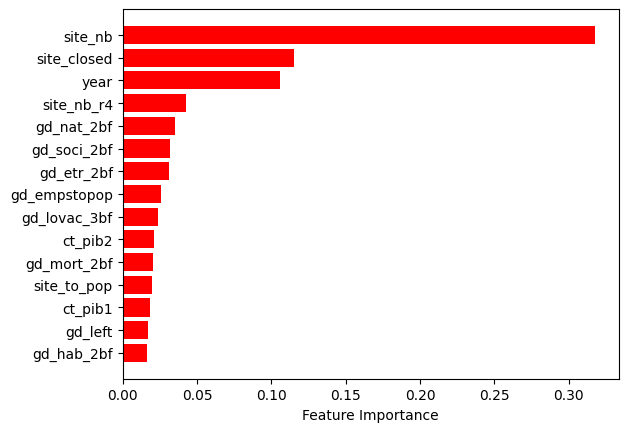

In [274]:
X = df_filtered.drop(['site_new'], axis=1)
y = df_filtered['site_new']

X = X.astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

adasyn = ADASYN()

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
print(f'Original: {Counter(y)}', f'train: {Counter(y_train)}',f'resampled: {Counter(y_train_resampled)}')
print(f'x shape: {X_train_resampled.shape}')
print(f'x shape: {y_train_resampled.shape}')

rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train_resampled, y_train_resampled)
sort = rf.feature_importances_.argsort()
top_15_features = sort[-15:]  # Get the indices of the 15 most important features
plt.barh(X_test.columns[top_15_features], rf.feature_importances_[top_15_features], color='red')
plt.xlabel("Feature Importance")
plt.show()